In [3]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statistics
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

from tensorflow import keras
from tensorflow.keras import Sequential,layers, regularizers, metrics
from tensorflow.keras.layers import Flatten, Dense,MaxPooling2D ,Dropout, BatchNormalization, AveragePooling1D, Reshape
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPool2D, LeakyReLU, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, UpSampling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import confusion_matrix, explained_variance_score, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, normalize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import f_regression

from numpy import unique
from numpy.linalg import eigh


from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

from scipy.stats import binom
from scipy.stats import zscore
from scipy import stats


def pair_match(dataset_match, dataset_f, pd_type): 
    pd_df=pd.read_excel(dataset_match)                 
    pd_df=pd_df.dropna()
    pd_df=pd_df.replace({'PROMT':''}, regex=True)
    pd_df['PD'] = pd_df['PD'].astype(int)
    pd_df['Control'] = pd_df['Control'].astype(int)
    PD_users = pd_df['PD'].tolist()
    C_users = pd_df['Control'].tolist()
    #PD_users = PD_users.astype(str)
    #C_users = C_users.astype(str)
    dictionary = {}
    for users in PD_users:
        dictionary[users] = 1
    for users in C_users:
        dictionary[users] = 0
    #print(dictionary)
    df_f=pd.read_excel(dataset_f)
    df_f=df_f.dropna()
    df_f=df_f.replace({'promt_':''}, regex=True)
    df_f['Subject_ID'] = df_f['Subject_ID'].astype(int)
    #pd_df.to_excel("PD_M.xlsx",sheet_name='PD_MAYBE')  
    #df_f.to_excel("F_M.xlsx",sheet_name='F_MAYBE')  
    #df_f['Subject_ID'] = df_f['Subject_ID'].astype(str)
    df_f['PD'] = df_f['Subject_ID'].map(dictionary)
    df_f = df_f[df_f['Type'] == pd_type]
    return df_f

def df_openclose(df_open, df_closed):
    #This concatenates the eyes closed as separate features to the eyes open.
    df_closed.columns = [str(col) + '_close' for col in df_closed.columns]
    first = df_closed.iloc[:10,:]
    second = df_closed.iloc[11:,:]
    df_closed = pd.concat([first, second])
    df_closed = df_closed.iloc[:, 33:]

    df_open.reset_index(inplace=True) # Resets the index, makes factor a column
    df_closed.reset_index(inplace=True) # Resets the index, makes factor a column

    #Concatenating
    #df_open = [df_open, df_closed]
    #df_open = [df_open, df_closed,df_post, df_post_close]
    df_open = pd.concat([df_open, df_closed], axis=1)
    df_open.drop(['index'],axis=1,inplace=True)
    df_full = df_open
    df_full = df_full.dropna()
    return df_full


def x_y_split_data(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

    
def anova_test(df, groups, drop = False):
    df_new = df
    for group in groups:
        df_new = df
        #df.loc[df['Group'] == group, 'name_match'] = 1  
        #df.loc[df['Group'] != group, 'name_match'] = 0  
        df_new['Class'] = df_new['PD'].apply(lambda x: 1 if x == group else 0)
        print(group)
        if drop == True:
            formula = 'Class ~  net_X_mean +  net_Z_mean + \
            net_X_std +  net_Z_std  + net_X_rms + \
            net_Z_rms +  net_area + mDIST + rDIST + pathN_filt + \
            mvN_filt + mFN_filt + Sway_Index + Stability_Index  + net_bos + \
            net_ratio'
        if drop == False:
            formula = 'Class ~ fp1_X_mean + fp2_X_mean + net_X_mean + fp1_Z_mean + fp2_Z_mean + net_Z_mean + \
            fp1_X_std + fp2_X_std + net_X_std + fp1_Z_std + fp2_Z_std + net_Z_std + fp1_X_rms + fp2_X_rms + net_X_rms + \
            fp1_Z_rms + fp2_Z_rms + net_Z_rms + fp1_area + fp2_area + net_area + mDIST + rDIST + pathN + pathN_filt + \
            mvN + mFN + mvN_filt + mFN_filt + Sway_Index + Stability_Index + fp1_bos + fp2_bos + net_bos + \
            fp1_ratio + fp2_ratio  + net_ratio'
        lm = ols(formula, df).fit()
        table = sm.stats.anova_lm(lm, typ=2)
        eta_squared(table)
        omega_squared(table)
        table.sort_values('PR(>F)',inplace=True,ascending=True)
        #table.to_excel (r'C:\Users\te5msride\Desktop\table.xlsx', index = True, header=True)
        display(table)

def process_scores(dataset,sheet,name): 
    #xls = pd.ExcelFile(dataset)
    if sheet == 'UPDRS':
        pd_df = pd.read_excel(dataset, sheet, usecols = "D:AG")  
        pd_df=pd_df.replace({"PROMT_":""}, regex=True)
        pd_df=pd_df.replace({"-":"0"}, regex=True)
        pd_df=pd_df.fillna(0)
        pd_df = pd_df.dropna(axis = 0, how ='any') 
        #print(pd_df.dtypes)
        pd_df=pd_df.astype(int)
        #print(pd_df.dtypes)
    if sheet == 'PROMT Clinical Database':
        pd_df = pd.read_excel(dataset, sheet)
        pd_df['Age'] = pd_df['Age']
    return pd_df

def process_hy(dataset): 
    #xls = pd.ExcelFile(dataset)
    pd_df = pd.read_excel(dataset)  
    pd_df=pd_df.replace({"PROMT":""}, regex=True)
    pd_df=pd_df.fillna(0)
    pd_df['ID#'] = pd_df['ID#'].astype(int)
    pd_df['H&Y Score'] = pd_df['H&Y Score'].astype(int)
    pd_df = pd_df[['ID#','H&Y Score']]
    pd_df=pd_df.astype(int)
    #print(pd_df.dtypes)
    return pd_df

        
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def nested_cross_val(X, Y, groups, validation_method, model, params):
    # print("Inner Cross Validation")
    # X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv=validation_method.split(X, Y, \
                                                                        groups)).fit(X, Y)
    # print(test_model.best_estimator_)
    # print(test_model.scorer_)
    return test_model.best_estimator_

def rsme(predictions, target):
    # root squared mean error
    return np.sqrt(((predictions - target) ** 2).mean())


# calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum()  # true positive
    total = matrix.sum()
    # print(tp)
    # print(total)
    return (tp * 1.0 / total)

def f1_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

def rsme(predictions, target):
    # root squared mean error
    return np.sqrt(((predictions - target) ** 2).mean())


def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

def binomial_range(x, N, confidence_level=0.95):
    # print("Calculate Binomal")
    # c_high = 1 - (confidence_level/2)
    # c_low = 1 - (confidence_level/2)
    prob = (x * 1.0) / N
    # use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0] / N, nums[1] / N
    # exact_confidence_interval(x, N, c_high, c_low)

def outer_cross_val(X, Y, groups, validation_method, model, params ,\
                    model_type = 'Classification', min_samples = 10, nested = False):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")
    best_fpr = 0
    best_tpr = 0
    best_train_index = []
    best_test_index = []
    labels_matrix = np.unique(Y)
   # print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification' or 'Class_F1' or 'Class_AUC' or 'Reg_R2':
        best_score = -5 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    for train_index, test_index in validation_method.split(X, Y, groups):
        #for each group split, do a nested cross validation
       # print(test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        nested_groups = groups[train_index]
        
        #optimized model from training set (validation done in nested function)
        if nested == True:
            best_nested_model = nested_cross_val(X_train, Y_train, nested_groups, \
                                                validation_method, model, params)
        if nested == False:
            best_nested_model = model.fit(X, Y)
        #print the parameters for the model in the nested 
        
        #print(best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)
        
        Y_pred = best_nested_model.predict(X_test)
        #probs = best_nested_model.predict_proba(X_test)
        #probs = probs[:, 1]
        Y_pred_q = np.round_(Y_pred, decimals = 0)
        #print(best_score)
        #nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        #print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
        
        #nested_score = rsme(Y_test, Y_pred)
        
        
        #nested_score = mean_absolute_error(Y_test,Y_pred)
        
        
        #print(nested_score)
        nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        nested_r2 = metrics.r2_score(Y_test,Y_pred)
        #print(Y_test)
        #print(min_samples)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if any(Y_pred <= 0):
                Y_pred[Y_pred<0] = 0
                nested_score = mean_squared_log_error(Y_test,Y_pred)
            else:
                nested_score = mean_squared_log_error(Y_test,Y_pred)
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_y_test = Y_test
                best_y_pred = Y_pred
                best_train_index = train_index
                best_test_index = test_index
                r2 = metrics.r2_score(Y_test,Y_pred)
                #print(r2)
            total_score += nested_score
        if model_type == 'Reg_R2':
            if best_score < nested_r2 and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:   
                best_model_overall = best_nested_model
                best_score = nested_r2
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_r2
        elif model_type == 'Classification':
            #if classification, compare accuracy
            nested_f1 = metrics.f1_score(Y_test, Y_pred_q, average='weighted')
            #compile all results for the confusion matrix
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_q, pos_label=1)
        
            auc = roc_auc_score(Y_test,Y_pred_q)
            print("AUROC = %0.3f" % (auc))
            ridge_fpr, ridge_tpr, _ = roc_curve(Y_test,Y_pred_q)
        
            nested_auc = metrics.auc(fpr, tpr)
            #print(nested_auc)
            consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
                                                labels=labels_matrix)
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy
        elif model_type == 'Class_F1':
            #if compare f1 score
            nested_f1 = metrics.f1_score(Y_test, Y_pred_q, average='weighted')
            #compile all results for the confusion matrix
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_q, pos_label=1)
        
#             auc = roc_auc_score(Y_test,Y_pred_q)
#             fpr, tpr, _ = roc_curve(Y_test,Y_pred_q)
        
#             nested_auc = metrics.auc(fpr, tpr)
            #print(nested_auc)
            consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
                                                labels=labels_matrix)
            if best_score < nested_f1 and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_f1
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_f1
        elif model_type == 'Class_AUC':
            #compile all results for the confusion matrix
            #fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_q, pos_label=1)
        
            #auc = roc_auc_score(Y_test,Y_pred_q)
            probs = best_nested_model.predict_proba(X_test)
            probs = probs[:, 1]
            fpr, tpr, _ = roc_curve(Y_test, probs)
            #fpr, tpr, _ = roc_curve(Y_test,Y_pred_q)
            probs = best_nested_model.predict_proba(X_test)
            probs = probs[:, 1]
            nested_auc = metrics.auc(fpr, tpr)
            
            #print(nested_auc)
            consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
                                                labels=labels_matrix)
            #if compare AUC score
            if best_score < nested_auc and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_auc
                best_y_test = Y_test
                best_y_pred = Y_pred
                best_train_index = train_index
                best_test_index = test_index
                best_fpr = fpr
                best_tpr = tpr
            total_score += nested_auc
                
        count += 1
        
    average_score = total_score/count
    #visualizer = ResidualsPlot(best_model_overall,hist = False,qqplot=True)
    #visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
    #visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
    #visualizer.show()                 # Finalize and render the figure
    
    #res = best_y_test-best_y_pred
    #plt.scatter(best_y_test,res, alpha=.5)
    if model_type == 'Reg_R2' or 'Regression':
        fig, ax = plt.subplots()
        ax.scatter(best_y_test,best_y_pred, alpha=.5)
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel('Actual Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title('Actual vs Predicted for Best SVR Model')
        fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_reg.svg' % subscore)
        plt.show()
    #plt.xlabel('Actual Value')
    #plt.ylabel('Predicted Value')
    #plt.title('Actual vs Predicted for Best SVR Model')
    final_scoring = best_score, average_score, consolidated_confusion_matrix, best_y_test, best_y_pred, best_fpr, best_tpr, best_train_index, best_test_index
  
    return best_model_overall, final_scoring

def accuracy_range(matrix):
    N = matrix.sum()
    acc = accuracy_from_confusion_matrix(matrix)
    low, high = binom.interval(0.95, N, acc)
    acc_range = (high/N - low/N)/2
    
    return acc, acc_range

def cross_validation_accuracy_regression(X, Y, model, folds):
    skf = StratifiedKFold(n_splits=folds)
    accuracy_scores = np.zeros(folds)
    count = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        #print(metrics.accuracy_score(Y_test, Y_pred.round()))
        accuracy_scores[count] = metrics.accuracy_score(Y_test, Y_pred.round())
        count += 1
    return accuracy_scores

def cross_validation_ROC(X, Y, model, folds):
    skf = StratifiedKFold(n_splits=folds)
    accuracy_scores = np.zeros(folds)
    nested_auc = np.zeros(folds)
    count = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        #print(metrics.accuracy_score(Y_test, Y_pred.round()))
        Y_pred_q = np.round_(Y_pred, decimals = 0)
        fpr, tpr, _ = roc_curve(Y_test,Y_pred_q)
        
        nested_auc[count] = metrics.auc(fpr, tpr)
        accuracy_scores[count] = metrics.accuracy_score(Y_test, Y_pred.round())
        count += 1
    return nested_auc

def encodeX(X,inputs, encoded):
    encoder = Model(inputs, encoded)
    encoded_X = encoder(X).numpy()
    return encoded_X

def create_subscores(df_data, df_scores, df_hy, df_age):
    #Create lists to prepare final dataset
    pd_patients = df_scores['Subject_ID'].tolist()
    
    #Age
    AGE = df_age['Age'].tolist()
    dict_age = {}
    dict_age = {pd_patients[i]: AGE[i] for i in range(len(pd_patients))}
    df_data['Age'] = df_data['Subject_ID'].map(dict_age)
    

    #UPDRS Total
    updrs = df_scores['Total Score'].tolist()
    dict_total = {}
    dict_total = {pd_patients[i]: updrs[i] for i in range(len(pd_patients))}
    df_data['UPDRS'] = df_data['Subject_ID'].map(dict_total)

    
    #H&Y Scores
    hy_scores = df_hy['H&Y Score'].tolist()
    dict_hy = {}
    dict_hy = {pd_patients[i]: hy_scores[i] for i in range(len(pd_patients))}
    df_data['H&Y'] = df_data['Subject_ID'].map(dict_hy)
    
    
    #Speech
    SPCH = df_scores['Speech'].tolist()
    dict_spch = {}
    dict_spch = {pd_patients[i]: SPCH[i] for i in range(len(pd_patients))}
    df_data['Speech'] = df_data['Subject_ID'].map(dict_spch)

    #Facial Expression
    FE = df_scores['Facial Expression'].tolist()
    dict_FE = {}
    dict_FE = {pd_patients[i]: FE[i] for i in range(len(pd_patients))}
    df_data['Facial Expression'] = df_data['Subject_ID'].map(dict_FE)

    #Tremor at rest
    TAR_H = df_scores['Tremor at Rest- Head'].tolist()
    dict_TAR_H = {}
    dict_TAR_H = {pd_patients[i]: TAR_H[i] for i in range(len(pd_patients))}
    df_data['Tremor at Rest- Head'] = df_data['Subject_ID'].map(dict_TAR_H)
    TAR_UL = df_scores['L UE'].tolist()
    dict_TAR_UL = {}
    dict_TAR_UL = {pd_patients[i]: TAR_UL[i] for i in range(len(pd_patients))}
    df_data['Tremor at Rest- Left UE'] = df_data['Subject_ID'].map(dict_TAR_UL)
    TAR_UR = df_scores['R UE'].tolist()
    dict_TAR_UR = {}
    dict_TAR_UR = {pd_patients[i]: TAR_UR[i] for i in range(len(pd_patients))}
    df_data['Tremor at Rest- Right UE'] = df_data['Subject_ID'].map(dict_TAR_UR)
    TAR_LL = df_scores['L LE'].tolist()
    dict_TAR_LL = {}
    dict_TAR_LL = {pd_patients[i]: TAR_LL[i] for i in range(len(pd_patients))}
    df_data['Tremor at Rest- Left LE'] = df_data['Subject_ID'].map(dict_TAR_LL)
    TAR_LR = df_scores['R LE'].tolist()
    dict_TAR_LR = {}
    dict_TAR_LR = {pd_patients[i]: TAR_LR[i] for i in range(len(pd_patients))}
    df_data['Tremor at Rest- Right LE'] = df_data['Subject_ID'].map(dict_TAR_LR)

    #Hand Tremor
    HT_L = df_scores['Hand Tremor- Left Hand'].tolist()
    dict_HT_L = {}
    dict_HT_L = {pd_patients[i]: HT_L[i] for i in range(len(pd_patients))}
    df_data['Hand Tremor- Left Hand'] = df_data['Subject_ID'].map(dict_HT_L)
    HT_R = df_scores['Right Hand'].tolist()
    dict_HT_R = {}
    dict_HT_R = {pd_patients[i]: HT_R[i] for i in range(len(pd_patients))}
    df_data['Hand Tremor- Right Hand'] = df_data['Subject_ID'].map(dict_HT_R)

    #Rigidity
    RIG_H = df_scores['Rigidity- Head'].tolist()
    dict_RIG_H = {}
    dict_RIG_H = {pd_patients[i]: RIG_H[i] for i in range(len(pd_patients))}
    df_data['Rigidity- Head'] = df_data['Subject_ID'].map(dict_RIG_H)
    RIG_UL = df_scores['L UE.1'].tolist()
    dict_RIG_UL = {}
    dict_RIG_UL = {pd_patients[i]: RIG_UL[i] for i in range(len(pd_patients))}
    df_data['Rigidity- Left UE'] = df_data['Subject_ID'].map(dict_RIG_UL)
    RIG_UR = df_scores['R UE.1'].tolist()
    dict_RIG_UR = {}
    dict_RIG_UR = {pd_patients[i]: RIG_UR[i] for i in range(len(pd_patients))}
    df_data['Rigidity- Right UE'] = df_data['Subject_ID'].map(dict_RIG_UR)
    RIG_LL = df_scores['L LE.1'].tolist()
    dict_RIG_LL = {}
    dict_RIG_LL = {pd_patients[i]: RIG_LL[i] for i in range(len(pd_patients))}
    df_data['Rigidity- Left LE'] = df_data['Subject_ID'].map(dict_RIG_LL)
    RIG_LR = df_scores['R LE.1'].tolist()
    dict_RIG_LR = {}
    dict_RIG_LR = {pd_patients[i]: RIG_LR[i] for i in range(len(pd_patients))}
    df_data['Rigidity- Right LE'] = df_data['Subject_ID'].map(dict_RIG_LR)

    #Finger Taps
    FT_L = df_scores['Finger Taps- Left Hand'].tolist()
    dict_FT_L = {}
    dict_FT_L = {pd_patients[i]: FT_L[i] for i in range(len(pd_patients))}
    df_data['Finger Taps- Left Hand'] = df_data['Subject_ID'].map(dict_FT_L)
    FT_R = df_scores['Right Hand.1'].tolist()
    dict_FT_R = {}
    dict_FT_R = {pd_patients[i]: FT_R[i] for i in range(len(pd_patients))}
    df_data['Finger Taps- Right Hand'] = df_data['Subject_ID'].map(dict_FT_R)

    #Hand Movements
    HM_L = df_scores['Hand Movements- Left Hand'].tolist()
    dict_HM_L = {}
    dict_HM_L = {pd_patients[i]: HM_L[i] for i in range(len(pd_patients))}
    df_data['Hand Movements- Left Hand'] = df_data['Subject_ID'].map(dict_HM_L)
    HM_R = df_scores['Right Hand.2'].tolist()
    dict_HM_R = {}
    dict_HM_R = {pd_patients[i]: HM_R[i] for i in range(len(pd_patients))}
    df_data['Hand Movements- Right Hand'] = df_data['Subject_ID'].map(dict_HM_R)

    #Alternating Hand Movements
    AHM_L = df_scores['Alternating Hand Movements- Left Hand'].tolist()
    dict_AHM_L = {}
    dict_AHM_L = {pd_patients[i]: AHM_L[i] for i in range(len(pd_patients))}
    df_data['Alternating Hand Movements- Left Hand'] = df_data['Subject_ID'].map(dict_AHM_L)
    AHM_R = df_scores['Right Hand.3'].tolist()
    dict_AHM_R = {}
    dict_AHM_R = {pd_patients[i]: AHM_R[i] for i in range(len(pd_patients))}
    df_data['Alternating Hand Movements- Right Hand'] = df_data['Subject_ID'].map(dict_AHM_R)

    #Leg Agility
    LA_L = df_scores['Leg Agility- Left Leg'].tolist()
    dict_LA_L = {}
    dict_LA_L = {pd_patients[i]: LA_L[i] for i in range(len(pd_patients))}
    df_data['Leg Agility- Left Leg'] = df_data['Subject_ID'].map(dict_LA_L)
    LA_R = df_scores['Right Leg'].tolist()
    dict_LA_R = {}
    dict_LA_R = {pd_patients[i]: LA_R[i] for i in range(len(pd_patients))}
    df_data['Leg Agility- Right Leg'] = df_data['Subject_ID'].map(dict_LA_R)

    #Arising from chair
    AFC = df_scores['Arising from Chair'].tolist()
    dict_AFC = {}
    dict_AFC = {pd_patients[i]: AFC[i] for i in range(len(pd_patients))}
    df_data['Arising from Chair'] = df_data['Subject_ID'].map(dict_AFC)

    #Posture
    POS = df_scores['Posture'].tolist()
    dict_POS = {}
    dict_POS = {pd_patients[i]: POS[i] for i in range(len(pd_patients))}
    df_data['Posture'] = df_data['Subject_ID'].map(dict_POS)

    #Gait
    GT = df_scores['Gait'].tolist()
    dict_GT = {}
    dict_GT = {pd_patients[i]: GT[i] for i in range(len(pd_patients))}
    df_data['Gait'] = df_data['Subject_ID'].map(dict_GT)

    #Postural Stability
    PS = df_scores['Postural Stability'].tolist()
    dict_PS = {}
    dict_PS = {pd_patients[i]: PS[i] for i in range(len(pd_patients))}
    df_data['Postural Stability'] = df_data['Subject_ID'].map(dict_PS)

    #Body Bradykinesia and Hypokinesia
    BB_H = df_scores['Body Bradykinesia and Hypokinesia'].tolist()
    dict_BB_H = {}
    dict_BB_H = {pd_patients[i]: BB_H[i] for i in range(len(pd_patients))}
    df_data['Body Bradykinesia and Hypokinesia'] = df_data['Subject_ID'].map(dict_BB_H)




    #Finalize training set
    df_data['Motor UPDRS'] = df_data['UPDRS'] - df_data['Speech']

    df_data = df_data[['Subject_ID','PD','Age','UPDRS', 'H&Y', 'Motor UPDRS', 'Speech', 'Facial Expression','Tremor at Rest- Head',
                         'Tremor at Rest- Left UE', 'Tremor at Rest- Right UE', 'Tremor at Rest- Left LE', 'Tremor at Rest- Right LE',
                         'Hand Tremor- Left Hand', 'Hand Tremor- Right Hand', 'Rigidity- Head', 'Rigidity- Left UE', 
                         'Rigidity- Right UE','Rigidity- Left LE', 'Rigidity- Right LE', 'Finger Taps- Left Hand', 
                         'Finger Taps- Right Hand', 'Hand Movements- Left Hand', 'Hand Movements- Right Hand',
                         'Alternating Hand Movements- Left Hand', 'Alternating Hand Movements- Right Hand',
                         'Leg Agility- Left Leg', 'Leg Agility- Right Leg', 'Arising from Chair', 'Posture','Gait',
                         'Postural Stability', 'Body Bradykinesia and Hypokinesia', 'L_cop_ap_std (mm)', 'R_cop_ap_std (mm)',
                         'N_cop_ap_std (mm)', 'L_cop_ml_std (mm)', 'R_cop_ml_std (mm)',
                         'N_cop_ml_std (mm)', 'L_cop_ap_rms (mm)', 'R_cop_ap_rms (mm)',
                         'N_cop_ap_rms (mm)', 'L_cop_ml_rms (mm)', 'R_cop_ml_rms (mm)',
                         'N_cop_ml_rms (mm)', 'L_RD_avg', 'R_RD_avg', 'N_RD_avg',
                         'L_RD_rms (mm)', 'R_RD_rms (mm)', 'N_RD_rms (mm)', 'TOTEX (mm)',
                         'VELO (mm/s)', 'ROT_FREQ (Hz)', 'Stability_index (deg)',
                         'Sway_index (deg)', 'L_cop_area (mm^2)', 'R_cop_area (mm^2)',
                         'N_cop_area (mm^2)', 'L_bos_area (mm^2)', 'R_bos_area (mm^2)',
                         'N_bos_area (mm^2)', 'L_area_ratio (mm^2)', 'R_area_ratio (mm^2)',
                         'N_area_ratio (mm^2)', 'L_rop_ap (mm)', 'R_rop_ap (mm)',
                         'N_rop_ap (mm)', 'L_rop_ml (mm)', 'R_rop_ml (mm)', 'N_rop_ml (mm)']]

    df_data = df_data.fillna(0)

    return df_data

def normalize_data(df, version = 'z'):
    if version == 'z':
        df_normalized = df.apply(zscore)
    if version == 'minmax':
        df_prep = df
        min_max_scaler = MinMaxScaler()
        df_normalized = min_max_scaler.fit_transform(df_prep)
    df_normalized['Subject_ID'] = df['Subject_ID']
    df_normalized['PD'] = df['PD']
    df_normalized['Age'] = df['Age']
    df_normalized['UPDRS'] = df['UPDRS']
    df_normalized['H&Y'] = df['H&Y']
    df_normalized['Motor UPDRS'] = df['Motor UPDRS']
    df_normalized['Speech'] = df['Speech']
    df_normalized['Facial Expression'] = df['Facial Expression']
    df_normalized['Tremor at Rest- Head'] = df['Tremor at Rest- Head']
    df_normalized['Tremor at Rest- Left UE'] = df['Tremor at Rest- Left UE']
    df_normalized['Tremor at Rest- Right UE'] = df['Tremor at Rest- Right UE']
    df_normalized['Tremor at Rest- Left LE'] = df['Tremor at Rest- Left LE']
    df_normalized['Tremor at Rest- Right LE'] = df['Tremor at Rest- Right LE']
    df_normalized['Hand Tremor- Left Hand'] = df['Hand Tremor- Left Hand']
    df_normalized['Hand Tremor- Right Hand'] = df['Hand Tremor- Right Hand']
    df_normalized['Rigidity- Head'] = df['Rigidity- Head']
    df_normalized['Rigidity- Left UE'] = df['Rigidity- Left UE']
    df_normalized['Rigidity- Right UE'] = df['Rigidity- Right UE']
    df_normalized['Rigidity- Left LE'] = df['Rigidity- Left LE']
    df_normalized['Rigidity- Right LE'] = df['Rigidity- Right LE']
    df_normalized['Finger Taps- Left Hand'] = df['Finger Taps- Left Hand']
    df_normalized['Finger Taps- Right Hand'] = df['Finger Taps- Right Hand']
    df_normalized['Hand Movements- Left Hand'] = df['Hand Movements- Left Hand']
    df_normalized['Hand Movements- Right Hand'] = df['Hand Movements- Right Hand']
    df_normalized['Alternating Hand Movements- Left Hand'] = df['Alternating Hand Movements- Left Hand']
    df_normalized['Alternating Hand Movements- Right Hand'] = df['Alternating Hand Movements- Right Hand']
    df_normalized['Leg Agility- Left Leg'] = df['Leg Agility- Left Leg']
    df_normalized['Leg Agility- Right Leg'] = df['Leg Agility- Right Leg']
    df_normalized['Arising from Chair'] = df['Arising from Chair']
    df_normalized['Posture'] = df['Posture']
    df_normalized['Gait'] = df['Gait']
    df_normalized['Postural Stability'] = df['Postural Stability']
    df_normalized['Body Bradykinesia and Hypokinesia'] = df['Body Bradykinesia and Hypokinesia']
    return df_normalized

def plot_by_patients(data, x_axis, y_axis, route = 'PCA',style = 'open',separate=False):
    green_dot = mlines.Line2D([], [], color='g', marker='.', linestyle = 'None',
            markersize = 20, label = 'Healthy',markeredgewidth = 1, markeredgecolor='k')
    red_dot = mlines.Line2D([], [], color='r', marker='.', linestyle = 'None',
            markersize = 20, label = 'PD', markeredgewidth = 1, markeredgecolor='k')
    blue_dot = mlines.Line2D([], [], color='b', marker='.', linestyle = 'None',
            markersize = 20, label = 'PD', markeredgewidth = 1, markeredgecolor='k')
    white_dot = mlines.Line2D([], [], color='w', marker='.', linestyle = 'None',
            markersize = 20, label = 'Healthy', markeredgewidth = 1, markeredgecolor='k')
    count_sev = [0 for i in range(0, 2)]
    for row in range(len(data)):
          
    #for i in range(len(transform_X[row])):
    #print(data_list_no_manual[row][13])
        if separate == True:
            if style == 'open':
                plt.legend(handles=[red_dot, green_dot], loc = 4)
                if data[row][1] == 1 and data[row][5] == 0:     
                    plt.plot(data[row][x_axis], data[row][y_axis],'r.', markersize=15, markeredgewidth = 1, markeredgecolor='k')
                    count_sev[0] += 1
                if data[row][1] == 0 and data[row][5] == 0:
                    plt.plot(data[row][x_axis], data[row][y_axis],'g.',markersize=15, markeredgewidth = 1,markeredgecolor='k')
                    count_sev[0] += 1
            if style == 'closed':
                plt.legend(handles=[blue_dot, white_dot], loc = 4)
                if data[row][1] == 1 and data[row][5] == 1:     
                    plt.plot(data[row][x_axis], data[row][y_axis],'b.', markersize=15, markeredgewidth = 1,markeredgecolor='k')
                    count_sev[0] += 1
                if data[row][1] == 0 and data[row][5] == 1:
                    plt.plot(data[row][x_axis], data[row][y_axis],'w.',markersize=15, markeredgewidth = 1,markeredgecolor='k')
                    count_sev[0] += 1
        if separate == False:
            if style == 'none':
                plt.legend(handles=[red_dot, green_dot], loc = 4)
                if data[row][1] == 1:     
                    plt.plot(data[row][x_axis], data[row][y_axis],'r.', markersize=15, markeredgewidth = 1, markeredgecolor='k')
                    count_sev[0] += 1
                if data[row][1] == 0:
                    plt.plot(data[row][x_axis], data[row][y_axis],'g.',markersize=15, markeredgewidth = 1,markeredgecolor='k')
                    count_sev[0] += 1

    
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    #plt.xlim(-400, 45)
    #plt.ylim(-200, 50)
    if route == 'PCA':
        plt.title("PCA")
    elif route == 'AE':
        plt.title("AE")
    
    plt.show() 
    
def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
              feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html     
    title:         Title for the heatmap. Default is None.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    #plt.savefig(plt.savefig((r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\ClassCM.svg' )))

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        elif model_type == "svr":
            regressor = SVR().fit(X,y)
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log

def forwardSelection(X, y, model_type ="linear",elimination_criteria = "r2", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    

    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    

    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    

    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def d3_to_2d(X):
    d2 = np.reshape(X,(X.shape[0],-1))
#     print(d2.shape)
    return d2

def p_val(df):  
    subscores = ['UPDRS','H&Y','Speech',
       'Facial Expression',  'Tremor at Rest- Left UE',
       'Tremor at Rest- Right UE', 'Hand Tremor- Left Hand',
       'Hand Tremor- Right Hand', 'Rigidity- Head', 'Rigidity- Left UE',
       'Rigidity- Right UE', 'Rigidity- Left LE', 'Rigidity- Right LE',
       'Finger Taps- Left Hand', 'Finger Taps- Right Hand',
       'Hand Movements- Left Hand', 'Hand Movements- Right Hand',
       'Alternating Hand Movements- Left Hand',
       'Alternating Hand Movements- Right Hand', 'Leg Agility- Left Leg',
       'Leg Agility- Right Leg', 'Arising from Chair', 'Posture', 'Gait',
       'Postural Stability', 'Body Bradykinesia and Hypokinesia']
    new_tab = pd.DataFrame()
    for subscore in subscores:
        index_subscore = df.columns.get_loc(subscore)
        X, Y = x_y_split_data(df.to_numpy(), 33, 70, index_subscore)
        P_val = list(f_regression(X,Y))
        P_table = pd.DataFrame(P_val).transpose()
        P_table.columns = ['F','P']
        P_table.index = ['L_cop_ap_std (mm)', 'R_cop_ap_std (mm)', 'N_cop_ap_std (mm)',
               'L_cop_ml_std (mm)', 'R_cop_ml_std (mm)', 'N_cop_ml_std (mm)',
               'L_cop_ap_rms (mm)', 'R_cop_ap_rms (mm)', 'N_cop_ap_rms (mm)',
               'L_cop_ml_rms (mm)', 'R_cop_ml_rms (mm)', 'N_cop_ml_rms (mm)',
               'L_RD_avg', 'R_RD_avg', 'N_RD_avg', 'L_RD_rms (mm)', 'R_RD_rms (mm)',
               'N_RD_rms (mm)', 'TOTEX (mm)', 'VELO (mm/s)', 'ROT_FREQ (Hz)',
               'Stability_index (deg)', 'Sway_index (deg)', 'L_cop_area (mm^2)',
               'R_cop_area (mm^2)', 'N_cop_area (mm^2)', 'L_bos_area (mm^2)',
               'R_bos_area (mm^2)', 'N_bos_area (mm^2)', 'L_area_ratio (mm^2)',
               'R_area_ratio (mm^2)', 'N_area_ratio (mm^2)', 'L_rop_ap (mm)',
               'R_rop_ap (mm)', 'N_rop_ap (mm)', 'L_rop_ml (mm)', 'R_rop_ml (mm)',
               'N_rop_ml (mm)']
        pvalues = P_table['P']
        r, pcorr, alph, ann = statsmodels.stats.multitest.multipletests(pvalues,alpha=.05,method='bonferroni')
        P_table['P_BF'] = pcorr
        P_table['Y/N'] = r
        P_table.sort_values('P',inplace=True,ascending=True)
        new_tab = new_tab.append(P_table.nsmallest(5,['P']))
        display(new_tab)
        #P_table.style.set_caption(subscore)
        #P_table.to_excel(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_pval.xlsx' % subscore)
        print(subscore)
        display(P_table)
    return new_tab
        
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

def compare_data(df, features = []):
    df_healthy = df[df['PD'] == 0]
    df_unhealthy = df[df['PD'] == 1]
    rows = []
    for feature in features:
        df_comp1 = df_healthy[feature]
        df_comp2 = df_unhealthy[feature]
        mean_healthy = statistics.mean(df_comp1)
        mean_pd = statistics.mean(df_comp2)
        #print(mean_healthy)
        #print(mean_pd)
        #This is for correlation between subscores to compare to random forest?
        #display(stats.pearsonr(df_healthy,df_unhealthy))
        df_data = pd.concat([df_healthy,df_unhealthy])
        #sns.boxplot(x = 'PD',y= feature, data=df_data)
        rows.append([mean_healthy, mean_pd])
        df_comparisons = pd.DataFrame(rows, columns=['Control','PD'])
    df_comparisons.index = features
    return df_comparisons

In [43]:
#Pre-OMT Data
df_match = pair_match("PROMT_PAIR#.xlsx", "promt_qs_fixed.xlsx", "Open")
df_close = pair_match("PROMT_PAIR#.xlsx", "promt_qs_fixed.xlsx", "Closed")

#Import UPDRS Scores
df_scores = process_scores("PROMT Clinical Database.xlsx", "UPDRS", "Subject_ID")
df_age = process_scores("PROMT Clinical Database.xlsx", "PROMT Clinical Database", "Subject_ID")
df_hy = process_hy('QS_Data_UPDRS.xlsx')

#dataset split
df_match = create_subscores(df_match, df_scores, df_hy, df_age)
df_close = create_subscores(df_close, df_scores, df_hy, df_age)

In [44]:
df_match = [df_match, df_close]
df_match = pd.concat(df_match)
df_match.drop(df_match[df_match['Subject_ID'] == 5].index, inplace = True)

In [ ]:
df_match

In [ ]:
df_heat = df_match.loc[:,'L_cop_ap_std (mm)':'N_rop_ml (mm)']
df = df_heat
#le = preprocessing.LabelEncoder()
df_clean = df.drop(columns=[i for i in df.columns[37:]])
#df_clean = df_clean.set_index('P')
#del df_clean.index.name
#print(df_clean)
corr = df_clean.corr(method = 'pearson')
sns.clustermap(corr, cmap='coolwarm')
#sns.clustermap(df_clean)

In [ ]:
#Current indices of importance are as follows: Subject_ID [0], Age [1], PD [2], UPDRS [3], H&Y [4], M-UPDRS [5], Subscores [6-32], features [33-69]
#if we are concat... Subject_ID [0], Age [1], PD [2], UPDRS [3], H&Y [4], M-UPDRS [5], Subscores [6-32], features [33-69] [70-106]
df_match.head()


In [ ]:
df_close.head()

In [ ]:
# df_match_omt.head()

In [ ]:
# df_match=df_close

In [ ]:
df_normalized = normalize_data(df_match, version = 'z')

In [ ]:
df_normalized = normalize_data(df_match, version = 'z')
#df_normalized = df_match
# min_max_scaler = MinMaxScaler()
# df_normalized[['fp1_X_mean','fp2_X_mean','net_X_mean','fp1_X_std','fp2_X_std','net_X_std','fp1_Z_std',
#  'fp2_Z_std','net_Z_std','fp1_X_rms','fp2_X_rms','net_X_rms','fp1_Z_mean','fp2_Z_mean','net_Z_mean','fp1_Z_rms',
#  'fp2_Z_rms','net_Z_rms','fp1_area','fp2_area','net_area','mDIST','mvN','mFN','mvN_filt','mFN_filt','Sway_Index',
#  'Stability_Index','fp1_bos','fp2_bos','net_bos','rDIST','pathN','pathN_filt','fp1_ratio','fp2_ratio','net_ratio',
#  'fp1_X_mean_close','fp2_X_mean_close','net_X_mean_close','fp1_X_std_close','fp2_X_std_close','net_X_std_close',
#  'fp1_Z_std_close','fp2_Z_std_close','net_Z_std_close','fp1_X_rms_close','fp2_X_rms_close','net_X_rms_close',
#  'fp1_Z_mean_close','fp2_Z_mean_close','net_Z_mean_close','fp1_Z_rms_close','fp2_Z_rms_close','net_Z_rms_close',
#  'fp1_area_close','fp2_area_close','net_area_close','mDIST_close','mvN_close','mFN_close','mvN_filt_close','mFN_filt_close',
#  'Sway_Index_close','Stability_Index_close','fp1_bos_close','fp2_bos_close','net_bos_close','rDIST_close','pathN_close',
#  'pathN_filt_close','fp1_ratio_close','fp2_ratio_close',
#  'net_ratio_close']] = min_max_scaler.fit_transform(df_match[['fp1_X_mean','fp2_X_mean','net_X_mean','fp1_X_std','fp2_X_std',
#  'net_X_std','fp1_Z_std','fp2_Z_std','net_Z_std','fp1_X_rms','fp2_X_rms','net_X_rms','fp1_Z_mean','fp2_Z_mean','net_Z_mean',
#  'fp1_Z_rms','fp2_Z_rms','net_Z_rms','fp1_area','fp2_area','net_area','mDIST','mvN','mFN','mvN_filt','mFN_filt','Sway_Index',
#  'Stability_Index','fp1_bos','fp2_bos','net_bos','rDIST','pathN','pathN_filt','fp1_ratio','fp2_ratio','net_ratio',
#  'fp1_X_mean_close','fp2_X_mean_close','net_X_mean_close','fp1_X_std_close','fp2_X_std_close','net_X_std_close',
#  'fp1_Z_std_close','fp2_Z_std_close','net_Z_std_close','fp1_X_rms_close','fp2_X_rms_close','net_X_rms_close',
#  'fp1_Z_mean_close','fp2_Z_mean_close','net_Z_mean_close','fp1_Z_rms_close','fp2_Z_rms_close','net_Z_rms_close',
#  'fp1_area_close','fp2_area_close','net_area_close','mDIST_close','mvN_close','mFN_close','mvN_filt_close','mFN_filt_close',
#  'Sway_Index_close','Stability_Index_close','fp1_bos_close','fp2_bos_close','net_bos_close','rDIST_close','pathN_close',
#  'pathN_filt_close','fp1_ratio_close','fp2_ratio_close','net_ratio_close']])
print(df_normalized)
X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 69, 1)
groups = df_normalized.to_numpy()[:, 0]
testing = 'Class_AUC'
selection = GroupKFold()
labels_for_matrix = np.unique(Y)

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

params_svc = {'gamma':[pow(10,i) for i in range(5,-6, -1)], 'C':[pow(10,j) for j in range(-5, 6, 1)]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr = SVC_scoring
orig_score = SVC_score
print(orig_score)

In [ ]:
#train model
#svc = SVC(C=10, gamma= 0.1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=41)

SVC(C = 10, gamma = .1).fit(X_train, Y_train)
#test
Y_pred = best_SVC.predict(X_test)
orig_auc = metrics.roc_auc_score(Y_test, Y_pred)
print(orig_auc)

In [ ]:
subscore_count =df_normalized.astype(bool).sum(axis=0)

In [ ]:
subscore_count =df_normalized.astype(bool).sum(axis=0)
subscore_count = subscore_count/2
print(subscore_count.to_string())

In [ ]:
yo = p_val(df_normalized)

In [ ]:
list = yo.transpose().columns

In [ ]:
ordered = []
frequency = {}
for item in list:
    if (item in frequency):
        frequency[item] += 1
    else:
        frequency[item] = 1
for key, value in frequency.items():
    print("% s -> % d" % (key, value))
    ordered.append([key, value])

In [ ]:
def Sort(sub_li):
  
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of 
    # sublist lambda has been used
    sub_li.sort(key = lambda x: x[1])
    return sub_li

Sort(ordered)

# PCA

In [ ]:
df_normalized.columns

In [45]:
df_normalized = df_match
scaler = MinMaxScaler()
df_normalized[['L_cop_ap_std (mm)', 'R_cop_ap_std (mm)', 'N_cop_ap_std (mm)',
       'L_cop_ml_std (mm)', 'R_cop_ml_std (mm)', 'N_cop_ml_std (mm)',
       'L_cop_ap_rms (mm)', 'R_cop_ap_rms (mm)', 'N_cop_ap_rms (mm)',
       'L_cop_ml_rms (mm)', 'R_cop_ml_rms (mm)', 'N_cop_ml_rms (mm)',
       'L_RD_avg', 'R_RD_avg', 'N_RD_avg', 'L_RD_rms (mm)', 'R_RD_rms (mm)',
       'N_RD_rms (mm)', 'TOTEX (mm)', 'VELO (mm/s)', 'ROT_FREQ (Hz)',
       'Stability_index (deg)', 'Sway_index (deg)', 'L_cop_area (mm^2)',
       'R_cop_area (mm^2)', 'N_cop_area (mm^2)', 'L_bos_area (mm^2)',
       'R_bos_area (mm^2)', 'N_bos_area (mm^2)', 'L_area_ratio (mm^2)',
       'R_area_ratio (mm^2)', 'N_area_ratio (mm^2)', 'L_rop_ap (mm)',
       'R_rop_ap (mm)', 'N_rop_ap (mm)', 'L_rop_ml (mm)', 'R_rop_ml (mm)',
       'N_rop_ml (mm)']] = scaler.fit_transform(df_match[['L_cop_ap_std (mm)', 'R_cop_ap_std (mm)', 'N_cop_ap_std (mm)',
       'L_cop_ml_std (mm)', 'R_cop_ml_std (mm)', 'N_cop_ml_std (mm)',
       'L_cop_ap_rms (mm)', 'R_cop_ap_rms (mm)', 'N_cop_ap_rms (mm)',
       'L_cop_ml_rms (mm)', 'R_cop_ml_rms (mm)', 'N_cop_ml_rms (mm)',
       'L_RD_avg', 'R_RD_avg', 'N_RD_avg', 'L_RD_rms (mm)', 'R_RD_rms (mm)',
       'N_RD_rms (mm)', 'TOTEX (mm)', 'VELO (mm/s)', 'ROT_FREQ (Hz)',
       'Stability_index (deg)', 'Sway_index (deg)', 'L_cop_area (mm^2)',
       'R_cop_area (mm^2)', 'N_cop_area (mm^2)', 'L_bos_area (mm^2)',
       'R_bos_area (mm^2)', 'N_bos_area (mm^2)', 'L_area_ratio (mm^2)',
       'R_area_ratio (mm^2)', 'N_area_ratio (mm^2)', 'L_rop_ap (mm)',
       'R_rop_ap (mm)', 'N_rop_ap (mm)', 'L_rop_ml (mm)', 'R_rop_ml (mm)',
       'N_rop_ml (mm)']])


In [46]:
testing = 'Regression'
subscores = ['UPDRS','H&Y','Speech',
       'Facial Expression',  'Tremor at Rest- Left UE',
       'Tremor at Rest- Right UE', 'Hand Tremor- Left Hand',
       'Hand Tremor- Right Hand', 'Rigidity- Head', 'Rigidity- Left UE',
       'Rigidity- Right UE', 'Rigidity- Left LE', 'Rigidity- Right LE',
       'Finger Taps- Left Hand', 'Finger Taps- Right Hand',
       'Hand Movements- Left Hand', 'Hand Movements- Right Hand',
       'Alternating Hand Movements- Left Hand',
       'Alternating Hand Movements- Right Hand', 'Leg Agility- Left Leg',
       'Leg Agility- Right Leg', 'Arising from Chair', 'Posture', 'Gait',
       'Postural Stability', 'Body Bradykinesia and Hypokinesia']
selection = GroupKFold()
#df_normalized = df_normalized[df_normalized['PD']==1]
groups = df_normalized.to_numpy()[:, 0]

In [ ]:
df_normalized = df_match
features = ['L_cop_ap_std (mm)', 'R_cop_ap_std (mm)', 'N_cop_ap_std (mm)',
       'L_cop_ml_std (mm)', 'R_cop_ml_std (mm)', 'N_cop_ml_std (mm)',
       'L_cop_ap_rms (mm)', 'R_cop_ap_rms (mm)', 'N_cop_ap_rms (mm)',
       'L_cop_ml_rms (mm)', 'R_cop_ml_rms (mm)', 'N_cop_ml_rms (mm)',
       'L_RD_avg', 'R_RD_avg', 'N_RD_avg', 'L_RD_rms (mm)', 'R_RD_rms (mm)',
       'N_RD_rms (mm)', 'TOTEX (mm)', 'VELO (mm/s)', 'ROT_FREQ (Hz)',
       'Stability_index (deg)', 'Sway_index (deg)', 'L_cop_area (mm^2)',
       'R_cop_area (mm^2)', 'N_cop_area (mm^2)', 'L_bos_area (mm^2)',
       'R_bos_area (mm^2)', 'N_bos_area (mm^2)', 'L_area_ratio (mm^2)',
       'R_area_ratio (mm^2)', 'N_area_ratio (mm^2)', 'L_rop_ap (mm)',
       'R_rop_ap (mm)', 'N_rop_ap (mm)', 'L_rop_ml (mm)', 'R_rop_ml (mm)',
       'N_rop_ml (mm)']

df_compare = compare_data(df_normalized, features)


In [ ]:
df_compare

UPDRS
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


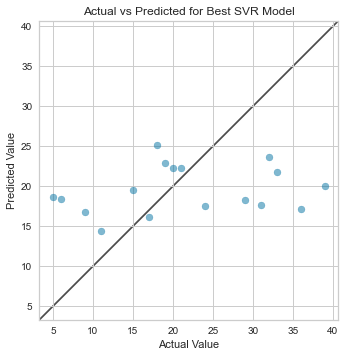

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   6.   7.   8.  16.  17.  19.  20.  21.  23.  25.  28.  30.
  44.  47.  51.  53.  55.  57.  59.  60.  64.  67.  74.  75.  76.]
[  4.   9.  14.  27.  43.  45.  52.  54.  56.  61.  63.  73.  77.  79.
  81.  97. 106.]
best score: 0.282866
average score: 0.372588 
Cohen Kappa: -0.035842
SVR(C=10, gamma=1)
[0.2828658345742988, 'UPDRS']
H&Y
Support vector regressor
Outer Cross Validation


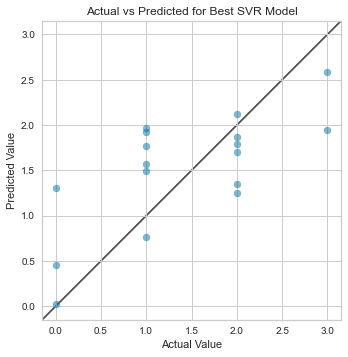

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  43.  44.  45.  47.  51.  52.  53.  54.  64.  67.]
[ 30.  55.  56.  57.  59.  60.  61.  63.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.095973
average score: 0.127952 
Cohen Kappa: 0.309645
SVR(C=10, gamma=1)
[0.09597274340848984, 'H&Y']
Speech
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


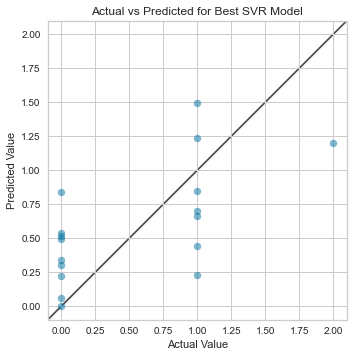

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  17.  19.  21.  55.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[16. 20. 23. 25. 27. 28. 30. 43. 44. 45. 47. 51. 52. 53. 54. 56. 57.]
best score: 0.097184
average score: 0.121642 
Cohen Kappa: 0.337662
SVR(C=10, gamma=1)
Facial Expression
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


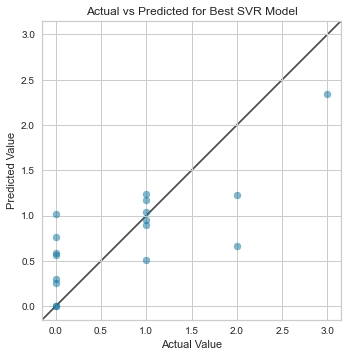

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.]
[ 21.  57.  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.113451
average score: 0.155052 
Cohen Kappa: 0.349727
SVR(C=10, gamma=1)
Tremor at Rest- Left UE
Support vector regressor
Outer Cross Validation


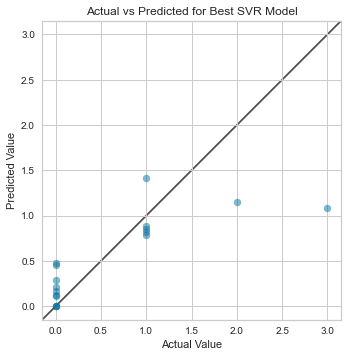

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  28.  52.  53.  59.  61.  64.  67.  74.  75.  77.  79. 106.   2.   4.
   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[27. 30. 43. 44. 45. 47. 51. 54. 55. 56. 57. 60. 63. 73. 76. 81. 97.]
best score: 0.061686
average score: 0.134905 
Cohen Kappa: 0.779221
SVR(C=10, gamma=1)
[0.06168586670603774, 'Tremor at Rest- Left UE']
Tremor at Rest- Right UE
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


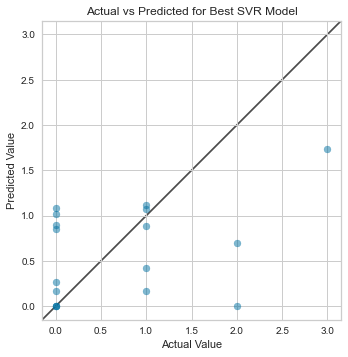

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  30.  43.  44.  45.  47.  51.  52.  55.  60.  64.]
[ 53.  54.  56.  57.  59.  61.  63.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.234787
average score: 0.304044 
Cohen Kappa: 0.125714
SVR(C=10, gamma=1)
Hand Tremor- Left Hand
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


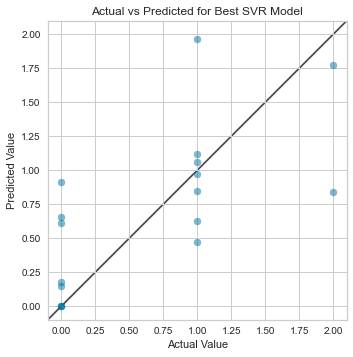

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  27.
  28.  43.  44.  51.  59.  74.  75.  77.  79.  81.  97. 106.   2.   4.
   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[25. 30. 45. 47. 52. 53. 54. 55. 56. 57. 60. 61. 63. 64. 67. 73. 76.]
best score: 0.087946
average score: 0.151357 
Cohen Kappa: 0.413793
SVR(C=10, gamma=1)
Hand Tremor- Right Hand
Support vector regressor
Outer Cross Validation


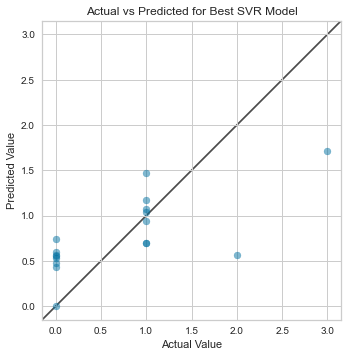

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  64.]
[ 55.  56.  57.  59.  60.  61.  63.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.122055
average score: 0.171930 
Cohen Kappa: 0.312139
SVR(C=10, gamma=1)
Rigidity- Head
Support vector regressor
Outer Cross Validation


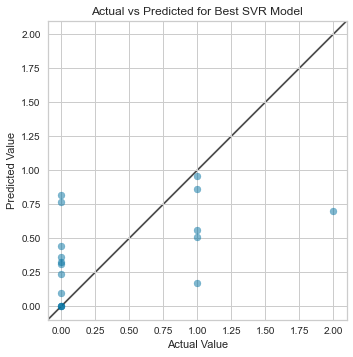

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   7.   8.   9.  14.  17.  19.  20.  27.  45.  47.  53.
  59.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 6. 16. 21. 23. 25. 28. 30. 43. 44. 51. 52. 54. 55. 56. 57. 60. 61.]
best score: 0.110106
average score: 0.163255 
Cohen Kappa: 0.527778
SVR(C=10, gamma=1)
Rigidity- Left UE
Support vector regressor
Outer Cross Validation


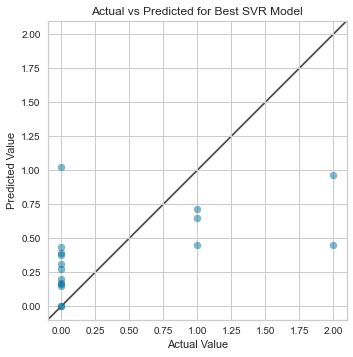

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  55.  56.  57.  60.
  63.  64.  67.  73.  74.  75.  76.  14.  16.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 54.  59.  61.  77.  79.  81.  97. 106.   2.   4.   6.   7.   8.   9.
  17.  19.  20.]
best score: 0.114067
average score: 0.157714 
Cohen Kappa: 0.438017
SVR(C=10, gamma=1)
Rigidity- Right UE
Support vector regressor
Outer Cross Validation


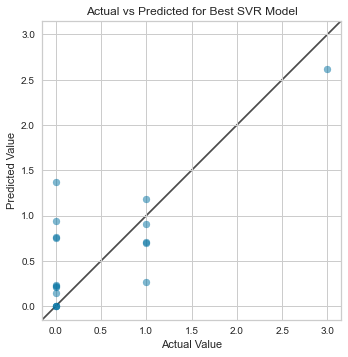

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  28.  30.  43.  44.  51.  52.  53.  55.  56.  57.  59.  60.  61.  63.
  64.  67.  73.  74.  75.  76.  77.   9.  17.  20.  21.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 27.  45.  47.  54.  79.  81.  97. 106.   2.   4.   6.   7.   8.  14.
  16.  19.  23.]
best score: 0.131700
average score: 0.178341 
Cohen Kappa: 0.468750
SVR(C=10, gamma=1)
Rigidity- Left LE
Support vector regressor
Outer Cross Validation


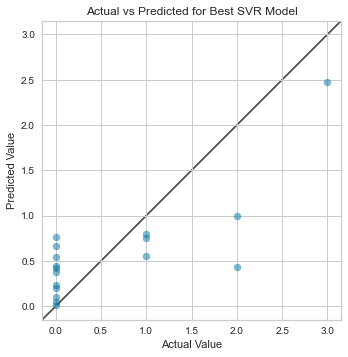

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  28.  30.  43.  44.  45.  47.  51.  52.  53.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  14.  16.  20.  21.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 27.  54.  76.  77.  79.  81.  97. 106.   2.   4.   6.   7.   8.   9.
  17.  19.  23.]
best score: 0.119942
average score: 0.241459 
Cohen Kappa: 0.389222
SVR(C=10, gamma=1)
Rigidity- Right LE
Support vector regressor
Outer Cross Validation


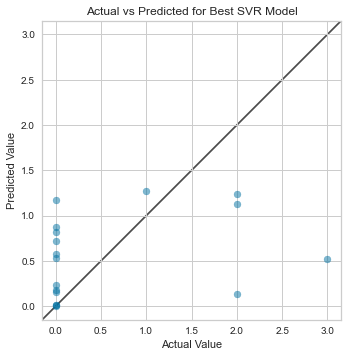

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   6.   7.   9.  16.  19.  20.  21.  23.  25.  27.  28.  30.
  47.  54.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 4.  8. 14. 17. 43. 44. 45. 51. 52. 53. 55. 56. 57. 59. 60. 61. 63.]
best score: 0.248649
average score: 0.290177 
Cohen Kappa: 0.128205
SVR(C=10, gamma=1)
Finger Taps- Left Hand
Support vector regressor
Outer Cross Validation


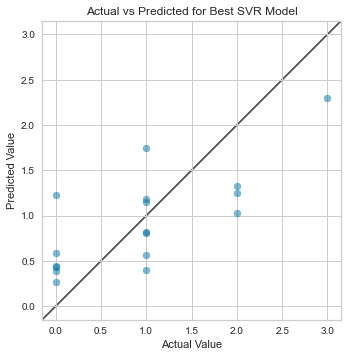

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  56.  57.  59.
  60.  61.  63.  64.  67.  73.  75.  14.  17.  20.  21.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 55.  74.  76.  77.  79.  81.  97. 106.   2.   4.   6.   7.   8.   9.
  16.  19.  23.]
best score: 0.113869
average score: 0.159854 
Cohen Kappa: 0.256831
SVR(C=10, gamma=1)
Finger Taps- Right Hand
Support vector regressor
Outer Cross Validation


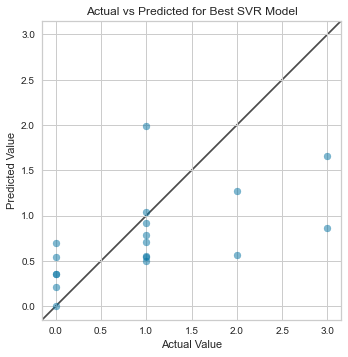

[ 17.  21.  25.  44.  51.  52.  54.  55.  56.  57.  59.  60.  61.  63.
  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.   2.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.  30.
  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.
  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 2.  4.  6.  7.  8.  9. 12. 14. 19. 20. 23. 27. 28. 30. 43. 45. 47. 53.]
best score: 0.130764
average score: 0.188126 
Cohen Kappa: 0.370000
SVR(C=10, gamma=1)
Hand Movements- Left Hand
Support vector regressor
Outer Cross Validation


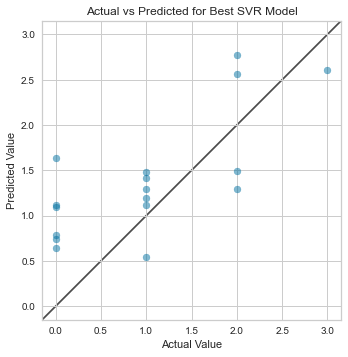

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  59.]
[ 55.  56.  57.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.195540
average score: 0.210713 
Cohen Kappa: 0.166667
SVR(C=10, gamma=1)
Hand Movements- Right Hand
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


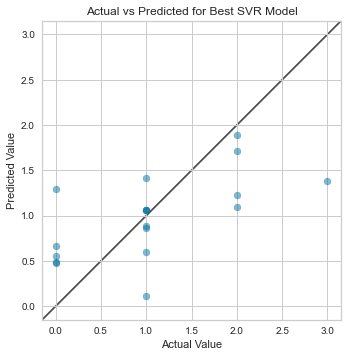

[ 28.  44.  45.  47.  52.  53.  54.  55.  56.  57.  59.  60.  61.  63.
  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.   2.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.  30.
  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.
  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 2.  4.  6.  7.  8.  9. 12. 14. 17. 19. 20. 21. 23. 25. 27. 30. 43. 51.]
best score: 0.132779
average score: 0.162602 
Cohen Kappa: 0.360406
SVR(C=10, gamma=1)
Alternating Hand Movements- Left Hand
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


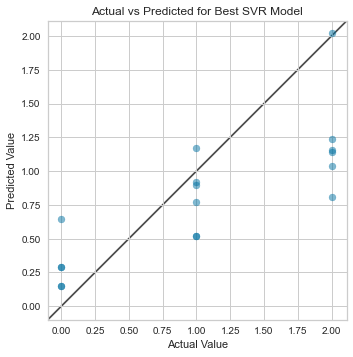

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  67.  73.  74.   9.  16.  19.  20.  21.  23.  25.
  27.  30.  43.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 64.  75.  76.  77.  79.  81.  97. 106.   2.   4.   6.   7.   8.  14.
  17.  28.  44.]
best score: 0.077215
average score: 0.201986 
Cohen Kappa: 0.465969
SVR(C=10, gamma=1)
Alternating Hand Movements- Right Hand
Support vector regressor
Outer Cross Validation


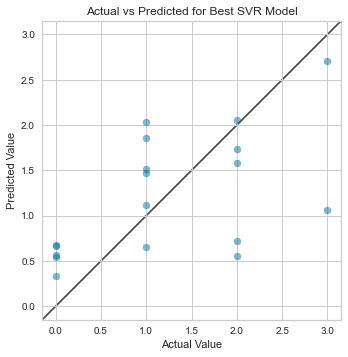

[ 23.  43.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.  63.
  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.   2.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.  30.
  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.
  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 2.  4.  6.  7.  8.  9. 12. 14. 17. 19. 20. 21. 25. 27. 28. 30. 44. 45.]
best score: 0.147568
average score: 0.206956 
Cohen Kappa: 0.207048
SVR(C=10, gamma=1)
Leg Agility- Left Leg
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


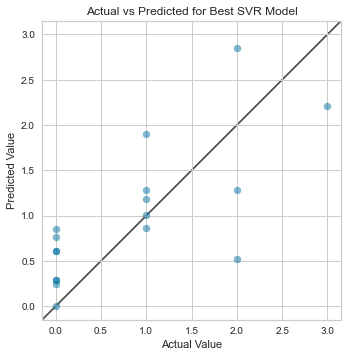

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  56.]
[ 55.  57.  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.126546
average score: 0.177448 
Cohen Kappa: 0.235000
SVR(C=10, gamma=1)
Leg Agility- Right Leg
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


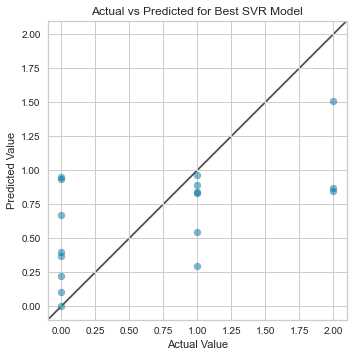

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  14.  20.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 74.  75.  76.  77.  79.  81.  97. 106.   2.   4.   6.   7.   8.   9.
  16.  17.  19.]
best score: 0.127937
average score: 0.179111 
Cohen Kappa: 0.426966
SVR(C=10, gamma=1)
Arising from Chair
Support vector regressor
Outer Cross Validation


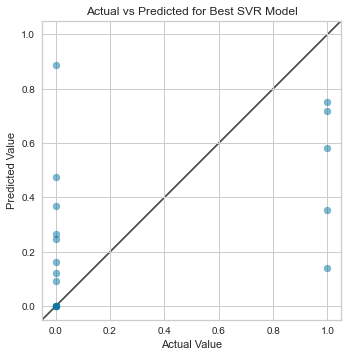

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  61.  67.  74.  75.  77.  79.  81.  97. 106.   2.   4.
   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[43. 44. 45. 47. 51. 52. 53. 54. 55. 56. 57. 59. 60. 63. 64. 73. 76.]
best score: 0.080276
average score: 0.106290 
Cohen Kappa: 0.548673
SVR(C=10, gamma=1)
Posture
Support vector regressor
Outer Cross Validation


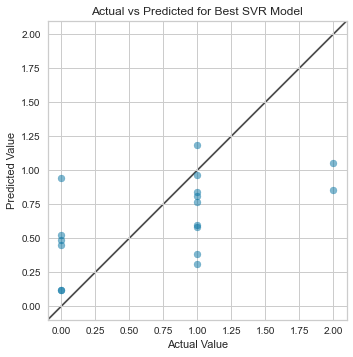

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  16.  17.  21.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[14. 19. 20. 23. 25. 27. 28. 30. 43. 44. 45. 47. 51. 52. 53. 54. 55.]
best score: 0.104447
average score: 0.128381 
Cohen Kappa: 0.337662
SVR(C=10, gamma=1)
Gait
Support vector regressor
Outer Cross Validation


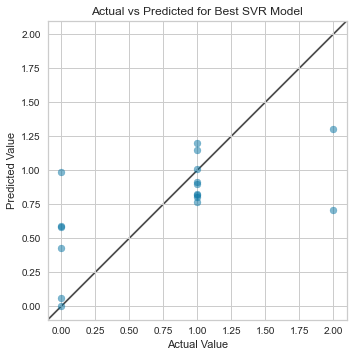

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.
  25.  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  55.  56.]
[ 54.  57.  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.
  81.  97. 106.]
best score: 0.086746
average score: 0.145024 
Cohen Kappa: 0.413793
SVR(C=10, gamma=1)
Postural Stability
Support vector regressor
Outer Cross Validation


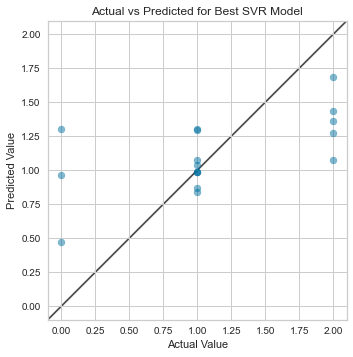

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  23.  25.  30.  43.
  44.  45.  51.  55.  67.  73.  74.  77.  79.  81.  97. 106.   2.   4.
   6.   7.   8.   9.  14.  16.  17.  19.  20.  21.  23.  25.  27.  28.
  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[20. 21. 27. 28. 47. 52. 53. 54. 56. 57. 59. 60. 61. 63. 64. 75. 76.]
best score: 0.098795
average score: 0.140373 
Cohen Kappa: 0.301370
SVR(C=10, gamma=1)
Body Bradykinesia and Hypokinesia
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


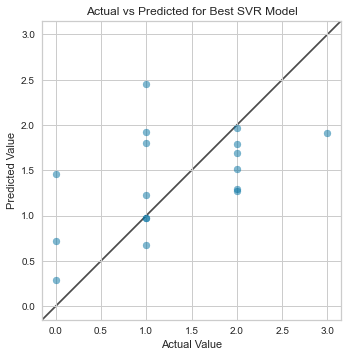

[  2.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.  23.  25.
  27.  28.  30.  43.  44.  45.  47.  51.  52.  53.  54.  55.  56.  57.
  59.  60.  61.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97.
 106.   2.   4.   6.  14.  16.  17.  19.  20.  23.  25.  28.  55.  57.
  60.  63.  64.  67.  73.  74.  75.  76.  77.  79.  81.  97. 106.]
[ 7.  8.  9. 21. 27. 30. 43. 44. 45. 47. 51. 52. 53. 54. 56. 59. 61.]
best score: 0.121574
average score: 0.145979 
Cohen Kappa: 0.252747
SVR(C=10, gamma=1)
[0.06168586670603774, 'Tremor at Rest- Left UE']


In [41]:
#Support Vector Regressor
testing = 'Regression'
selection = StratifiedKFold()
if testing == 'Regression':
    best_SVR_sub = [10000, '']
else:
    best_SVR_sub = [0, '']
SVR_sub = []
to_excel =[]
results = []
nested = False

for subscore in subscores:
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X_reg, Y_reg = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
#     scale = StandardScaler()
#     scale.fit(X_reg)
    
    #support vector regressor
    print("Support vector regressor")

    params_svr = {'gamma':[pow(10,i) for i in range(8,-5, -1)], 'C':[pow(10,j) for j in range(-5, 5, 1)]}

    best_SVR, SVR_scoring = outer_cross_val(X_reg, Y_reg, groups, selection, SVR(gamma = 1, C = 10), params_svr, testing, 2, nested)

    SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring
    print(groups[ok1])
    print(groups[ok2])
    Y_pred_q = np.round_(Y_pred, decimals = 0)
    print("best score: %.6f" % SVR_score)
    print("average score: %.6f " % average_SVR)
    best_SVR_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
    print("Cohen Kappa: %.6f" % best_SVR_kappa)
    print(best_SVR)
    metric = SVR_score
    metric_avg = average_SVR
    results.append([subscore, metric, metric_avg])
    #to_excel.append([subscore, best_SVR, SVR_score])
    if testing == 'Regression':
        if SVR_score < best_SVR_sub[0]:
            best_SVR_sub = [SVR_score,subscore]
            print(best_SVR_sub)
    else:
        if SVR_score > best_SVR_sub[0]:
            best_SVR_sub = [SVR_score,subscore]
            print(best_SVR_sub)
print(best_SVR_sub)

UPDRS
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


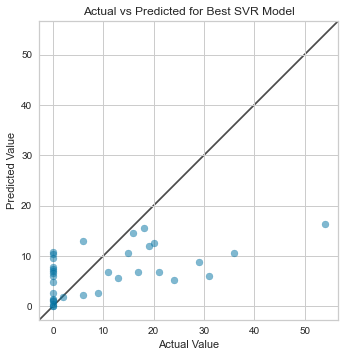

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   6.   7.   8.  16.  17.  19.  20.  21.  22.  25.
  26.  27.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.
  42.  44.  47.  50.  51.  52.  53.  55.  56.  57.  60.  65.  67.  70.
  74.  76.  81.  84.  85.  87.  89.  90.  91.  93.]
[  4.   9.  14.  23.  28.  43.  45.  54.  59.  61.  63.  64.  73.  75.
  77.  79.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 1.739068
average score: 2.383903 
Cohen Kappa: 0.067642
SVR(C=10, gamma=1)
[1.739068287430937, 'UPDRS']
H&Y
Support vector 

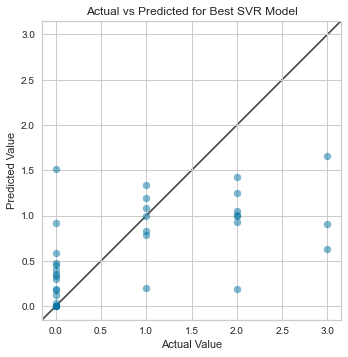

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  51.  52.  53.  54.  60.
  64.  67.  81.  84.  85.  87.  89.  90.  91.  93.]
[ 30.  50.  55.  56.  57.  59.  61.  63.  65.  70.  73.  74.  75.  76.
  77.  79.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.167422
average score: 0.258811 
Cohen Kappa: 0.372032
SVR(C=10, gamma=1)
[0.16742234769985084, 'H&Y']
Speech
Support vect

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


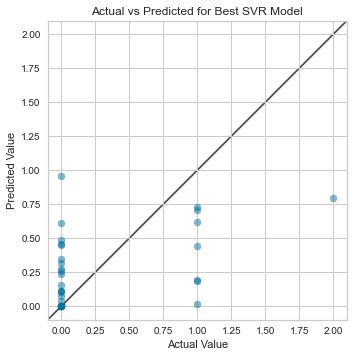

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  47.  74.  76.  99. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[44. 45. 50. 51. 52. 53. 54. 55. 56. 57. 59. 60. 61. 63. 64. 65. 67. 70.
 73. 75. 77. 79. 81. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96. 97.]
best score: 0.087083
average score: 0.125536 
Cohen Kappa: 0.383420
SVR(C=10, gamma=1)
[0.08708260870745525, 'Speech']
Facial Expression
Support vector regressor
Outer Cr

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


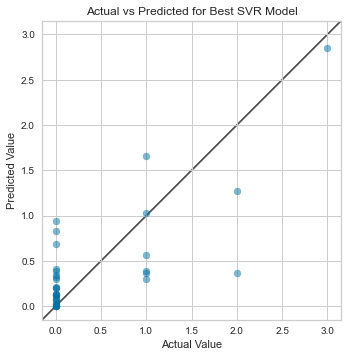

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   9.  16.  19.  20.  21.  22.  23.
  25.  26.  29.  30.  31.  32.  59.  60.  61.  63.  73.  76.  79.  81.
  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101.
 102. 103. 105. 107. 108. 109. 110. 111. 112. 113.]
[  8.  14.  17.  27.  28.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  64.  65.
  67.  70.  74.  75.  77. 106.]
best score: 0.088885
average score: 0.136721 
Cohen Kappa: 0.344754
SVR(C=10, gamma=1)
Tremor at Rest- Left UE
Support vector regressor

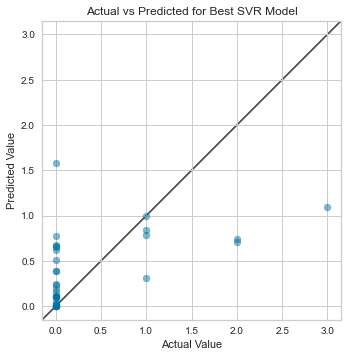

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  52.  53.  74.  81.  97.  99. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[42. 43. 44. 45. 47. 50. 51. 54. 55. 56. 57. 59. 60. 61. 63. 64. 65. 67.
 70. 73. 75. 76. 77. 79. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96.]
best score: 0.119249
average score: 0.155026 
Cohen Kappa: 0.306122
SVR(C=10, gamma=1)
Tremor at Rest- Right UE
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


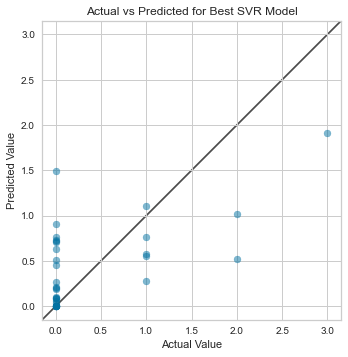

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  26.  27.  28.  52.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[23. 25. 29. 30. 31. 32. 33. 34. 35. 36. 37. 39. 40. 41. 42. 43. 44. 45.
 47. 50. 51. 53. 54. 55. 56. 57. 59. 60. 61. 63. 64. 65. 67. 70.]
best score: 0.125641
average score: 0.213581 
Cohen Kappa: 0.308475
SVR(C=10, gamma=1)
Hand Tremor- Left Hand
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


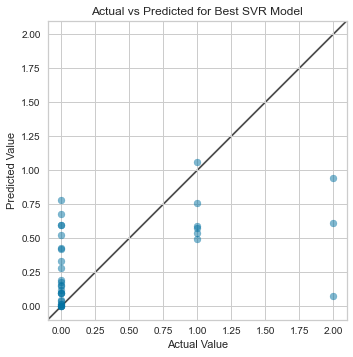

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  43.  44.  51.  74.  76.  97. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[42. 45. 47. 50. 52. 53. 54. 55. 56. 57. 59. 60. 61. 63. 64. 65. 67. 70.
 73. 75. 77. 79. 81. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96. 99.]
best score: 0.107566
average score: 0.159737 
Cohen Kappa: 0.426966
SVR(C=10, gamma=1)
Hand Tremor- Right Hand
Support vector regressor
Outer Cross Validation


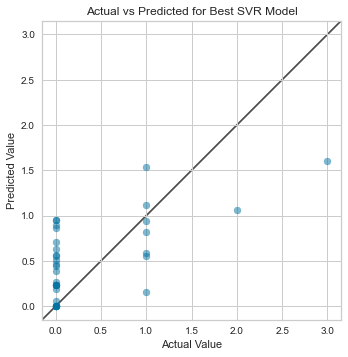

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  22.
  23.  26.  29.  30.  52.  55.  59.  67.  74.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[20. 21. 25. 27. 28. 31. 32. 33. 34. 35. 36. 37. 39. 40. 41. 42. 43. 44.
 45. 47. 50. 51. 53. 54. 56. 57. 60. 61. 63. 64. 65. 70. 73. 75.]
best score: 0.125100
average score: 0.168157 
Cohen Kappa: 0.291667
SVR(C=10, gamma=1)
Rigidity- Head
Support vector regressor
Outer Cross Validation


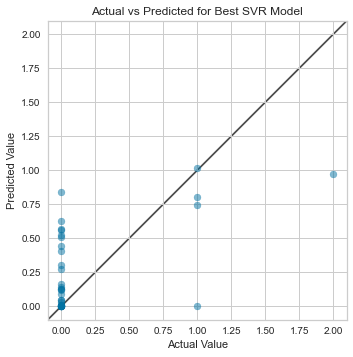

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  26.  27.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.
  40.  41.  42.  43.  50.  51.  52.  53.  59.  64. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[25. 28. 44. 45. 47. 54. 55. 56. 57. 60. 61. 63. 65. 67. 70. 73. 74. 75.
 76. 77. 79. 81. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96. 97. 99.]
best score: 0.073819
average score: 0.090249 
Cohen Kappa: 0.352381
SVR(C=10, gamma=1)
[0.07381914853247175, 'Rigidity- Head']
Rigidity- Left UE
Support vector regressor


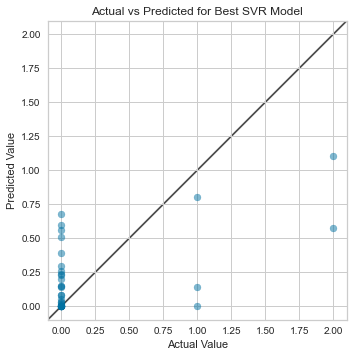

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  22.
  23.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.
  40.  41.  42.  43.  47.  50.  51.  52.  54.  59. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[21. 25. 44. 45. 53. 55. 56. 57. 60. 61. 63. 64. 65. 67. 70. 73. 74. 75.
 76. 77. 79. 81. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96. 97. 99.]
best score: 0.077366
average score: 0.097740 
Cohen Kappa: 0.227273
SVR(C=10, gamma=1)
Rigidity- Right UE
Support vector regressor
Outer Cross Validation


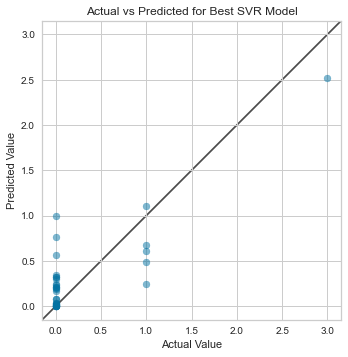

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  50.  51.  52.  53.  55.  56.
  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.
  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99.
  17.  20.  21.  25.  28.  30.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 47.  54. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  19.  22.  23.
  26.  27.  29.  31.  32.  33.]
best score: 0.058420
average score: 0.099847 
Cohen Kappa: 0.539295
SVR(C=10, gamma=1)
[0.05841963253417504, 'Rigidity- Right UE']
Rigi

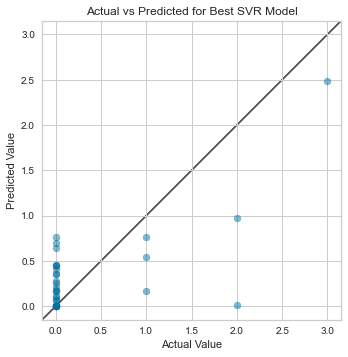

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  22.
  23.  25.  26.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.
  40.  41.  42.  43.  44.  45.  50.  51.  52.  53.  55.  56.  57.  59.
  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.
  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99.   4.   9.
  14.  16.  20.  21.  25.  27.  28.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 21.  27.  47.  54. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110.
 111. 112. 113.   1.   2.   3.   6.   7.   8.  17.  19.  22.  23.  26.
  29.  30.  31.  32.  33.  34.]
best score: 0.104798
average score: 0.145418 
Cohen Kappa: 0.373684
SVR(C=10, gamma=1)
Rigidity- Right LE
Support vector regressor
Oute

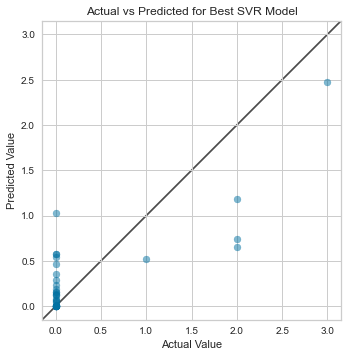

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.
  39.  40.  41.  42.  43.  44.  45.  50.  51.  52.  53.  55.  56.  57.
  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.
  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99.   2.
   9.  14.  17.  21.  25.  27.  28.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 27.  47.  54. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111.
 112. 113.   1.   3.   4.   6.   7.   8.  16.  19.  20.  22.  23.  26.
  29.  30.  31.  32.  33.  34.]
best score: 0.071529
average score: 0.175745 
Cohen Kappa: 0.352381
SVR(C=10, gamma=1)
Finger Taps- Left Hand
Support vector regressor


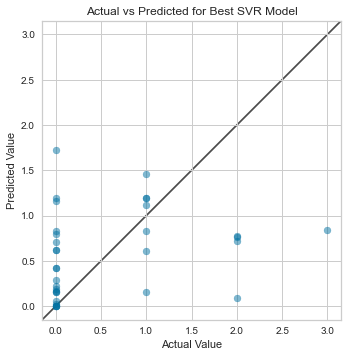

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  54.
  56.  57.  64.  65.  70.  73.  75.  77.  79.  84.]
[ 53.  55.  59.  60.  61.  63.  67.  74.  76.  81.  85.  87.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.207584
average score: 0.226850 
Cohen Kappa: 0.301028
SVR(C=10, gamma=1)
Finger Taps- Right Hand
Support vector regressor

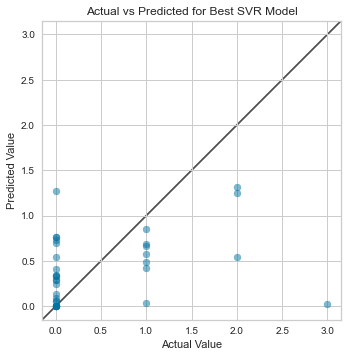

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  45.  47.  50.  51.  52.  53.  54.  56.
  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.  77.  79.
  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  99. 100.  14.  17.
  20.  21.  25.  27.  28.  30.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 44.  55.  76.  81.  97. 101. 102. 103. 105. 106. 107. 108. 109. 110.
 111. 112. 113.   1.   2.   3.   4.   6.   7.   8.   9.  16.  19.  22.
  23.  26.  29.  31.  32.  33.]
best score: 0.172279
average score: 0.214824 
Cohen Kappa: 0.240550
SVR(C=10, gamma=1)
Hand Movements- Left Hand
Support vector regress

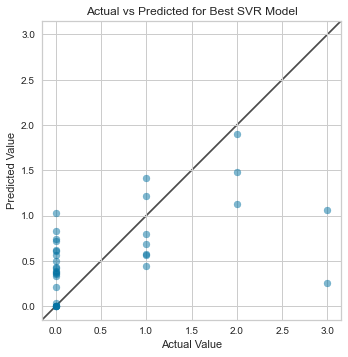

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  53.  54.
  56.  57.  60.  64.  65.  67.  70.  75.  79.  84.]
[ 52.  55.  59.  61.  63.  73.  74.  76.  77.  81.  85.  87.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.156091
average score: 0.194478 
Cohen Kappa: 0.351906
SVR(C=10, gamma=1)
Hand Movements- Right Hand
Support vector regres

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


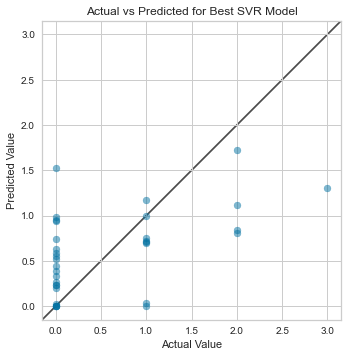

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  65.  67.  70.  79.  84.  85.]
[ 28.  60.  61.  63.  64.  73.  74.  75.  76.  77.  81.  87.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.170793
average score: 0.209604 
Cohen Kappa: 0.281690
SVR(C=10, gamma=1)
Alternating Hand Movements- Left Hand
Support ve

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


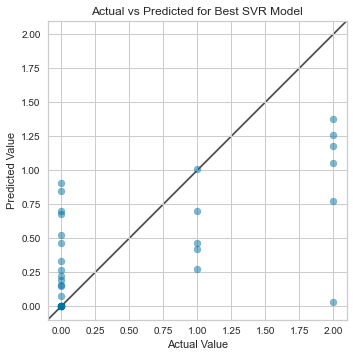

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  65.  67.  70.  73.  74.  75.  76.  79.
  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.  99. 100. 101.  14.
  17.  20.  21.  25.  27.  31.  32.  33.  34.  35.  36.  37.  39.  40.
  41.  42.  43.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 63.  64.  77.  81.  97. 102. 103. 105. 106. 107. 108. 109. 110. 111.
 112. 113.   1.   2.   3.   4.   6.   7.   8.   9.  16.  19.  22.  23.
  26.  28.  29.  30.  44.  45.]
best score: 0.122242
average score: 0.171051 
Cohen Kappa: 0.193220
SVR(C=10, gamma=1)
Alternating Hand Movements- Right Hand
Support v

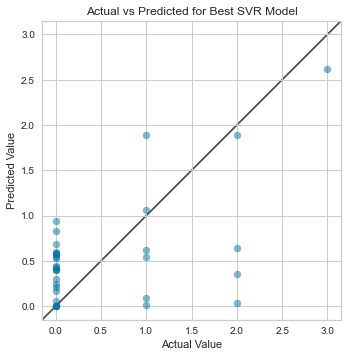

[ 28.  43.  45.  47.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.
  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.  85.
  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 1.  2.  3.  4.  6.  7.  8.  9. 12. 14. 17. 19. 20. 21. 22. 23. 25. 26.
 27. 29. 30. 31. 32. 33. 34. 35. 36. 37. 39. 40. 41. 42. 44. 50.]
best score: 0.185587
average score: 0.228214 
Cohen Kappa: 0.221374
SVR(C=10, gamma=1)
Leg Agility- Left Leg
Support vector regressor
Outer Cross Validation


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


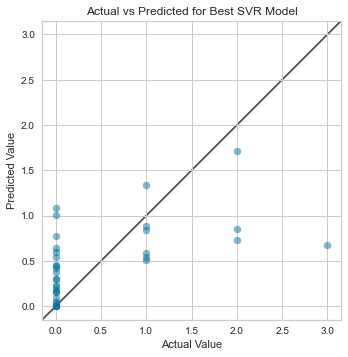

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.
  56.  57.  59.  63.  65.  67.  70.  75.  79.  84.]
[ 54.  55.  60.  61.  64.  73.  74.  76.  77.  81.  85.  87.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.127584
average score: 0.159139 
Cohen Kappa: 0.515055
SVR(C=10, gamma=1)
Leg Agility- Right Leg
Support vector regressor


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


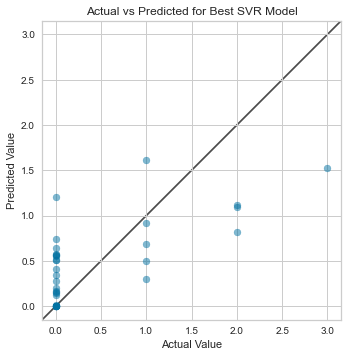

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  45.  50.  51.  52.  53.  54.  55.  56.
  57.  59.  60.  63.  64.  65.  67.  70.  75.  79.]
[ 28.  44.  47.  61.  73.  74.  76.  77.  81.  84.  85.  87.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.111157
average score: 0.151051 
Cohen Kappa: 0.136508
SVR(C=10, gamma=1)
Arising from Chair
Support vector regressor
Oute

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


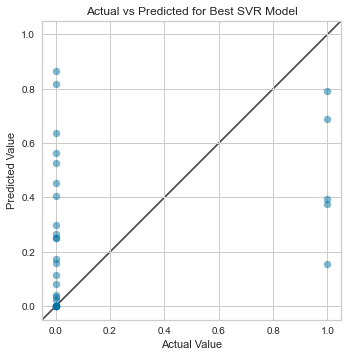

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  61.  81.  97.  99. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[44. 45. 47. 50. 51. 52. 53. 54. 55. 56. 57. 59. 60. 63. 64. 65. 67. 70.
 73. 74. 75. 76. 77. 79. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96.]
best score: 0.074189
average score: 0.084700 
Cohen Kappa: 0.195266
SVR(C=10, gamma=1)
Posture
Support vector regressor
Outer Cross Validation


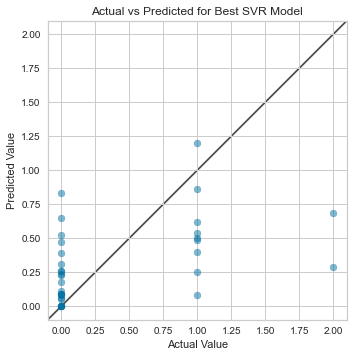

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  44.  51.  73.  77.  81.  97. 100. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[42. 43. 45. 47. 50. 52. 53. 54. 55. 56. 57. 59. 60. 61. 63. 64. 65. 67.
 70. 74. 75. 76. 79. 84. 85. 87. 89. 90. 91. 93. 94. 95. 96. 99.]
best score: 0.101596
average score: 0.130169 
Cohen Kappa: 0.388000
SVR(C=10, gamma=1)
Gait
Support vector regressor
Outer Cross Validation


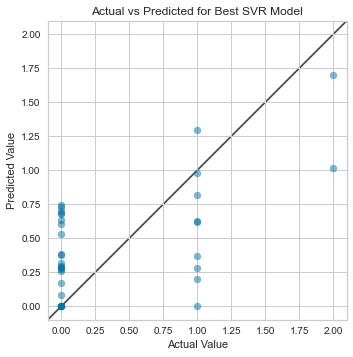

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  20.  22.
  23.  26.  29.  31.  54.  60.  61.  63.  73.  74.  76.  77.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[19. 21. 25. 27. 28. 30. 32. 33. 34. 35. 36. 37. 39. 40. 41. 42. 43. 44.
 45. 47. 50. 51. 52. 53. 55. 56. 57. 59. 64. 65. 67. 70. 75. 79.]
best score: 0.119672
average score: 0.136343 
Cohen Kappa: 0.252115
SVR(C=10, gamma=1)
Postural Stability
Support vector regressor
Outer Cross Validation


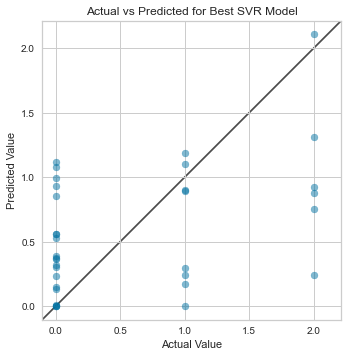

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  53.  55.
  56.  57.  59.  65.  67.  70.  79.  84.  85.  87.]
[ 52.  54.  60.  61.  63.  64.  73.  74.  75.  76.  77.  81.  89.  90.
  91.  93.  94.  95.  96.  97.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 111. 112. 113.]
best score: 0.183578
average score: 0.200863 
Cohen Kappa: 0.152493
SVR(C=10, gamma=1)
Body Bradykinesia and Hypokinesia
Support vector

C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


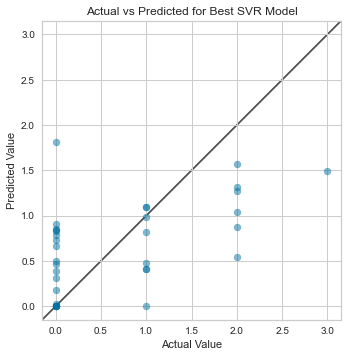

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  44.  45.  67.  74.  75.  77.  79.  81.  97. 103.
 105. 106. 107. 108. 109. 110. 111. 112. 113.   1.   2.   3.   4.   6.
   7.   8.   9.  14.  16.  17.  19.  20.  21.  22.  23.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  39.  40.  41.  42.
  43.  44.  45.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  61.  63.  64.  65.  67.  70.  73.  74.  75.  76.  77.  79.  81.  84.
  85.  87.  89.  90.  91.  93.  94.  95.  96.  97.  99. 100. 101. 102.
 103. 105. 106. 107. 108. 109. 110. 111. 112. 113.]
[ 42.  43.  47.  50.  51.  52.  53.  54.  55.  56.  57.  59.  60.  61.
  63.  64.  65.  70.  73.  76.  84.  85.  87.  89.  90.  91.  93.  94.
  95.  96.  99. 100. 101. 102.]
best score: 0.178005
average score: 0.209389 
Cohen Kappa: 0.153527
SVR(C=10, gamma=1)
[0.05841963253417504, 'Rigidity- Right UE']


In [39]:
#Support Vector Regressor
testing = 'Regression'
selection = StratifiedKFold()
if testing == 'Regression':
    best_SVR_sub = [10000, '']
else:
    best_SVR_sub = [0, '']
SVR_sub = []
to_excel =[]
results = []
nested = False

for subscore in subscores:
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X_reg, Y_reg = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
#     scale = StandardScaler()
#     scale.fit(X_reg)
    
    #support vector regressor
    print("Support vector regressor")

    params_svr = {'gamma':[pow(10,i) for i in range(8,-5, -1)], 'C':[pow(10,j) for j in range(-5, 5, 1)]}

    best_SVR, SVR_scoring = outer_cross_val(X_reg, Y_reg, groups, selection, SVR(gamma = 1, C = 10), params_svr, testing, 2, nested)

    SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring
    print(groups[ok1])
    print(groups[ok2])
    Y_pred_q = np.round_(Y_pred, decimals = 0)
    print("best score: %.6f" % SVR_score)
    print("average score: %.6f " % average_SVR)
    best_SVR_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
    print("Cohen Kappa: %.6f" % best_SVR_kappa)
    print(best_SVR)
    metric = SVR_score
    metric_avg = average_SVR
    results.append([subscore, metric, metric_avg])
    #to_excel.append([subscore, best_SVR, SVR_score])
    if testing == 'Regression':
        if SVR_score < best_SVR_sub[0]:
            best_SVR_sub = [SVR_score,subscore]
            print(best_SVR_sub)
    else:
        if SVR_score > best_SVR_sub[0]:
            best_SVR_sub = [SVR_score,subscore]
            print(best_SVR_sub)
print(best_SVR_sub)

In [11]:
print(groups[ok1])
print(groups[ok2])

[]
[]


In [ ]:
df_reg = pd.DataFrame(results)
df_reg.columns = ['Subscore', 'Best', 'Avg']
df_reg.sort_values('Avg', inplace=True, ascending=True)
display(df_reg)
# fig,ax = render_mpl_table(df_reg, header_columns=0, col_width=5)
# fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\top_sub.svg')

In [ ]:
selection = GroupKFold()
testing = 'Regression'
if testing == 'Regression':
    best_ridge_sub = [10000, '']
else:
    best_ridge_sub = [0, '']
ridge_sub = []
to_excel =[]
for subscore in subscores:
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X_reg, Y_reg = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
    
    warnings.filterwarnings('ignore')


    params_ridge = {'solver':['auto'],
         'alpha':[pow(10, i)for i in range (-5, 40)]}
    best_ridge, ridge_scoring = outer_cross_val(X_reg, Y_reg, groups, selection, Ridge(), params_ridge, testing, 3)
    ridge_score, average_ridge, ridge_cm, Y_test, Y_pred, _, _, _, _ = ridge_scoring
    Y_pred_q = np.round_(Y_pred, decimals=0)  
    best_ridge_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)

    print("best score: %.6f" % ridge_score)
    print("average score: %.6f " % average_ridge)
    print("Cohen Kappa: %.6f" % best_ridge_kappa)

    print(best_ridge)
    to_excel.append([subscore, best_ridge, ridge_score])
    if testing == 'Regression':
        if ridge_score < best_ridge_sub[0]:
            best_ridge_sub = [ridge_score,subscore]
            print(best_ridge_sub)
    else:
        if ridge_score > best_ridge_sub[0]:
            best_ridge_sub = [ridge_score,subscore]
            print(best_ridge_sub)
print(best_ridge_sub)

In [ ]:
selection = GroupKFold()
results=[]
testing = 'Regression'
if testing == 'Regression':
    best_lasso_sub = [10000, '']
else:
    best_lasso_sub = [0, '']
lasso_sub = []
to_excel =[]
for subscore in subscores:
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X_reg, Y_reg = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
    
    warnings.filterwarnings('ignore')


    params_lasso = {'alpha': [pow(10, i) for i in range(-5, 5)]}
    best_lasso, lasso_scoring = outer_cross_val(X_reg, Y_reg, groups, selection, Lasso(), params_lasso, testing, 3)
    lasso_score, average_lasso, lasso_cm, Y_test, Y_pred, _, _, _, _ = lasso_scoring
    Y_pred_q = np.round_(Y_pred, decimals=0)  
    best_lasso_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
    metric = lasso_score
    metric_avg = average_lasso
    print("best score: %.6f" % lasso_score)
    print("average score: %.6f " % average_lasso)
    print("Cohen Kappa: %.6f" % best_lasso_kappa)
    results.append([subscore, metric, metric_avg])
    print(best_lasso)
    to_excel.append([subscore, best_lasso, lasso_score])
    if testing == 'Regression':
        if lasso_score < best_lasso_sub[0]:
            best_lasso_sub = [lasso_score,subscore]
            print(best_lasso_sub)
    else:
        if lasso_score > best_lasso_sub[0]:
            best_lasso_sub = [lasso_score,subscore]
            print(best_lasso_sub)
print(best_lasso_sub)

In [ ]:
#selection = GroupShuffleSplit(n_splits=3)
testing = 'Regression'
if testing == 'Regression':
    best_logreg_sub = [10000, '']
else:
    best_logreg_sub = [0, '']
logreg_sub = []
to_excel =[]
for subscore in subscores:
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X_reg, Y_reg = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
    
    warnings.filterwarnings('ignore')


    params_logreg = {'solver':['newton-cg'],
         'C':[pow(10, i)for i in range (-5, 5)]}
    best_logreg, logreg_scoring = outer_cross_val(X_reg, Y_reg, groups, selection, LogisticRegression(), params_logreg, testing, 3)
    logreg_score, average_logreg, logreg_cm, Y_test, Y_pred, _, _, _, _ = logreg_scoring
    Y_pred_q = np.round_(Y_pred, decimals=0)  
    best_logreg_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)

    print("best score: %.6f" % logreg_score)
    print("average score: %.6f " % average_logreg)
    print("Cohen Kappa: %.6f" % best_logreg_kappa)

    print(best_logreg)
    to_excel.append([subscore, best_logreg, logreg_score])
    if testing == 'Regression':
        if logreg_score < best_logreg_sub[0]:
            best_logreg_sub = [logreg_score,subscore]
            print(best_logreg_sub)
    else:
        if logreg_score > best_logreg_sub[0]:
            best_logreg_sub = [logreg_score,subscore]
            print(best_logreg_sub)
print(best_logreg_sub)

In [ ]:
subscores = ['UPDRS','H&Y','Speech',
       'Facial Expression',  'Tremor at Rest- Left UE',
       'Tremor at Rest- Right UE', 'Hand Tremor- Left Hand',
       'Hand Tremor- Right Hand', 'Rigidity- Head', 'Rigidity- Left UE',
       'Rigidity- Right UE', 'Rigidity- Left LE', 'Rigidity- Right LE',
       'Finger Taps- Left Hand', 'Finger Taps- Right Hand',
       'Hand Movements- Left Hand', 'Hand Movements- Right Hand',
       'Alternating Hand Movements- Left Hand',
       'Alternating Hand Movements- Right Hand', 'Leg Agility- Left Leg',
       'Leg Agility- Right Leg', 'Arising from Chair', 'Posture', 'Gait',
       'Postural Stability', 'Body Bradykinesia and Hypokinesia']
print("Using the GridSearchCV to find the best parameter")
for subscore in subscores:
    Ydif = 0
    print(subscore)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 70, index_subscore)
    
    Y_C = Y
    #Y = Y*10
    parameters = {'n_estimators':[100+10*n for n in range(1,10)],
                'criterion':['gini', 'entropy'], 
                'min_samples_split':[i for i in range(2, 10)]}

    RF = RandomForestClassifier()
    clf_RF = GridSearchCV(RF, parameters, cv=5)

    results_RF = clf_RF.fit(X, Y_C)
    print(results_RF.best_estimator_)

    NUMBER_OF_RUNS = 20
    FEATURES = 38

    feat_importance = random_forest_n_runs_feat_importance(X, Y_C, results_RF.best_estimator_, NUMBER_OF_RUNS, FEATURES )
    avg_feat_importance = np.zeros(FEATURES)
    for f in range(len(feat_importance)):
        avg_feat_importance[f]= feat_importance[f].mean()

    #print(avg_feat_importance)
    feat_importance = pd.Series(avg_feat_importance, index = df_normalized.columns[33:71]).sort_values()
    #print(feat_importance)
    fi = pd.DataFrame(feat_importance, columns=None)
    fi.to_excel(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\Random Forest Tables\%r_Feature_Importance.xlsx' % subscore)
    plt.figure(figsize=(9,7))
    feat_importance.plot(kind='barh')
    plt.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\Random Forest Bar graphs\%r_rf_imp.svg' % subscore)
    plt.show()

In [ ]:
fi = pd.DataFrame(feat_importance, columns=None)

In [ ]:
fi.to_excel(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_Feature_Importance.xlsx' % subscore)

In [ ]:
#PCA dimentionality reduction

pca_data = df_normalized.loc[:,'L_cop_ap_std (mm)':'N_rop_ml (mm)']

#print(pca_data)

## If Min-max scaling
#min_max_scaler = MinMaxScaler()
#pca_data = min_max_scaler.fit_transform(pca_data)

## If z-scaling
#pca_data = pca_data.apply(zscore)


NUMBER_OF_COMPONENTS = 20
    
pca = decomposition.PCA(n_components = NUMBER_OF_COMPONENTS)
pca.fit(pca_data)
transform_X = pca.transform(pca_data)

#print(transform_X)
#rebuild the data
header_df = df_normalized.loc[:, 'Subject_ID':'PD']
#header_df['Group']=header_df['Group'].map(lambda group:group.upper())

#label_encoder = LabelEncoder()
#y_data = label_encoder.fit_transform(header_df['PD'])

y_data = header_df['PD']
#print (y_data)
#print (header_df)

header_arr = header_df.to_numpy()
#footer_df = df_match.loc[:,'net_ratio':'Eyes']
#footer_arr = footer_df.to_numpy()

#print(footer_arr)
transformed_data_arr = np.hstack((header_arr, transform_X))
#print(transformed_data_arr)

print("Overall")
print(pca.explained_variance_ratio_)
#for components in range(NUMBER_OF_COMPONENTS):
    #comp = pca.components_[components]
    #print("Component %i explains ratio %.6f" % ((components + 1),pca.explained_variance_ratio_[components]) )
    #sorted_index = np.argsort(comp)
    #for i in reversed(range(len(sorted_index))):
        #print("%.6f\t%s" % (comp[sorted_index[i]], pca_data.columns[sorted_index[i]]))
    #print("")
    
#plot points for each Patient
 


#plt.figure(figsize=(10,6))
#plot_by_patients(transformed_data_arr, 2, 3, 'PCA', 'none', separate = False)
#plot_by_patients(transformed_data_arr, 2, 3, 'PCA', 'closed')

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Variance of PCA')

In [ ]:
component_list = [2, 3, 4]
for i in range(5, 20, 1):
    component_list.append(i)
testing = 'Reg_R2'
#for i in range(100, 550, 50):
#    component_list.append(i)
    
print(component_list)

results = []
roc_list = []
var_list = []
subscore = 'UPDRS'
for c in component_list:
    #print(X)
    index_subscore = df_normalized.columns.get_loc(subscore)
    X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 69, index_subscore)
    pca = decomposition.PCA(n_components = c)
    pca.fit(X)
    pca_X = pca.transform(X)
    #print(pca_X)
    params_svc = {'gamma':[pow(10,i) for i in range(5,-6, -1)], 'C':[pow(10,j) for j in range(-5, 6, 1)]}

    best_SVC, SVC_scoring = outer_cross_val(pca_X, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
    SVC_score, average_SVC, SVC_cm, Y_test, Y_pred, SVC_fpr, SVC_tpr, _, _ = SVC_scoring
    #print(SVC_score)
    pca_metric = SVC_score
    var = sum(pca.explained_variance_ratio_)
    results.append([c, pca_metric, var])
    roc_list.append(pca_metric)
    var_list.append(var)
    print("Number of components: %i, Accuracy:%.6f, Variance: %.6f" %(c, pca_metric, var))
    #plt.plot(SVC_fpr, SVC_tpr, marker='.', markersize=12, label='SVC %i components (AUROC = %0.3f)' % (c, SVC_score))
    #plt.title('ROC Plot')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.legend()
    #plt.show()
    
line1=plt.plot(component_list, roc_list)
line2=plt.plot(component_list, var_list)
plt.axhline(y=orig_score, color = 'k', linestyle = ':')
plt.xlabel("# of PCA Components")
plt.ylabel("Percentage")
plt.legend((line1[0], line2[0]), ('Accuracy', 'Variance'))
plt.show()

In [ ]:
#PCA dimentionality reduction

pca_data = df_normalized.loc[:,'L_cop_ap_std (mm)':'N_rop_ml (mm)']

#print(pca_data)

## If Min-max scaling
#min_max_scaler = MinMaxScaler()
#pca_data = min_max_scaler.fit_transform(pca_data)

## If z-scaling
#pca_data = pca_data.apply(zscore)


NUMBER_OF_COMPONENTS = 2
    
pca = decomposition.PCA(n_components = NUMBER_OF_COMPONENTS)
pca.fit(pca_data)
transform_X = pca.transform(pca_data)

#print(transform_X)
#rebuild the data
header_df = df_match.loc[:, 'Subject_ID':'PD']
#header_df['Group']=header_df['Group'].map(lambda group:group.upper())

#label_encoder = LabelEncoder()
#y_data = label_encoder.fit_transform(header_df['PD'])

y_data = header_df['PD']
#print (y_data)
#print (header_df)

header_arr = header_df.to_numpy()
#footer_df = df_match.loc[:,'net_ratio':'Eyes']
#footer_arr = footer_df.to_numpy()

#print(footer_arr)
transformed_data_arr = np.hstack((header_arr, transform_X))
#print(transformed_data_arr)

print("Overall")
print(pca.explained_variance_ratio_)
for components in range(NUMBER_OF_COMPONENTS):
    comp = pca.components_[components]
    print("Component %i explains ratio %.6f" % ((components + 1),pca.explained_variance_ratio_[components]) )
    sorted_index = np.argsort(comp)
    for i in reversed(range(len(sorted_index))):
        print("%.6f\t%s" % (comp[sorted_index[i]], pca_data.columns[sorted_index[i]]))
    print("")
    
#plot points for each Patient
 


plt.figure(figsize=(10,6))
plot_by_patients(transformed_data_arr, 2, 3, 'PCA', 'none', separate = False)
#plot_by_patients(transformed_data_arr, 2, 3, 'PCA', 'closed')

#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance');
#plt.title('Variance of PCA')

In [ ]:
pca = decomposition.PCA(n_components = 3)
pca.fit(X)
pca_X = pca.transform(X)
categories = [ "Healthy", "PD"]
params_svc = {'gamma':[pow(10,i) for i in range(5,-6, -1)], 'C':[pow(10,j) for j in range(-5, 6, 1)]}

best_SVC, SVC_scoring = outer_cross_val(pca_X, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
make_confusion_matrix(SVC_cm, categories = categories)

In [ ]:
component_list = [2, 3, 4]
for i in range(5, 30, 1):
    component_list.append(i)
    
#for i in range(100, 550, 50):
#    component_list.append(i)
    
print(component_list)

results = []
roc_list = []
var_list = []

for c in component_list:
    pca = decomposition.PCA(n_components = c)
    pca.fit(X_train)
    t_X_train = pca.transform(X_train)
    t_X_test = pca.transform(X_test)
    
    best_SVC.fit(t_X_train, Y_train)
    t_y_pred = best_SVC.predict(t_X_test)
    auc = metrics.roc_auc_score(Y_test, t_y_pred)
    var = sum(pca.explained_variance_ratio_)
    results.append([c, auc, var])
    roc_list.append(auc)
    var_list.append(var)
    print("Number of components: %i, Accuracy:%.6f, Variance: %.6f" %(c, auc, var))
    
line1=plt.plot(component_list, roc_list)
line2=plt.plot(component_list, var_list)
plt.axhline(y=orig_auc, color = 'k', linestyle = ':')
plt.xlabel("# of PCA Components")
plt.ylabel("Percentage")
plt.legend((line1[0], line2[0]), ('Accuracy', 'Variance'))
plt.show()

In [18]:
#Classification
X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 70, 1)
groups = df_normalized.to_numpy()[:, 0]
print(groups)
categories = [ "Healthy", "PD"]

#Choose splitter class and optimization parameter for nested CV, create labels for confusion matrices
testing = 'Class_AUC'
selection = StratifiedKFold()
labels_for_matrix = np.unique(Y)

[  1.   2.   3.   4.   6.   7.   8.   9.  12.  14.  17.  19.  20.  21.
  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.  54.
  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.  75.
  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.  96.
  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111. 112.
 113.   1.   2.   3.   4.   6.   7.   8.   9.  14.  16.  17.  19.  20.
  21.  22.  23.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  39.  40.  41.  42.  43.  44.  45.  47.  50.  51.  52.  53.
  54.  55.  56.  57.  59.  60.  61.  63.  64.  65.  67.  70.  73.  74.
  75.  76.  77.  79.  81.  84.  85.  87.  89.  90.  91.  93.  94.  95.
  96.  97.  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 110. 111.
 112. 113.]


In [ ]:
print("Ridge")
#alpha from 10^-5 to 10^5
#remove solver
#hyperparameters selected for the models selected
#compare results with original paper
#look at inter-rater reliability for comparison (clinician 1 vs clinician 2) 
#kappa values between prediction - cinician diagnosis

params = {'solver':['auto'],
         'alpha':[pow(10, i)for i in range (-5, 40)]}
best_ridge, ridge_scoring = outer_cross_val(X, Y, groups, selection, Ridge(), params, testing, 3)
ridge_score, average_ridge, ridge_cm, Y_test, Y_pred, ridge_fpr, ridge_tpr= ridge_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)
best_ridge_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_ridge_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
print("best score: %.6f" % ridge_score)
print("average score: %.6f " % average_ridge)
print("Cohen Kappa: %.6f" % best_ridge_kappa)
#print("Consolidated Confusion Matrix ")
#print(ridge_cm)
label = ['Healthy', 'PD']
result_cm = matrix_scores(ridge_cm.astype(float))
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(ridge_cm)))
print(best_ridge)
#print(best_ridge.coef_)
print(metrics.classification_report(Y_test, Y_pred_q, target_names = categories))
print("Ridge")
make_confusion_matrix(ridge_cm, categories = categories)
#sns.heatmap(ridge_cm, annot=True)

In [ ]:
print("Log Reg (l2)")
#alpha from 10^-5 to 10^5
#remove solver
#hyperparameters selected for the models selected
#compare results with original paper
#look at inter-rater reliability for comparison (clinician 1 vs clinician 2) 
#kappa values between prediction - cinician diagnosis

params = {'solver':['newton-cg'],
         'C':[pow(10, i)for i in range (-5, 10)]}
best_log_l2, log_l2_scoring = outer_cross_val(X, Y, groups, selection, LogisticRegression(penalty='l2'), params, testing, 3)
log_l2_score, average_log_l2, log_l2_cm, Y_test, Y_pred, log_l2_fpr, log_l2_tpr,l2_train_index, l2_test_index= log_l2_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)
best_log_l2_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_log_l2_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
print("best score: %.6f" % log_l2_score)
print("average score: %.6f " % average_log_l2)
print("Cohen Kappa: %.6f" % best_log_l2_kappa)
#print("Consolidated Confusion Matrix ")
#print(log_l2_cm)
label = ['Healthy', 'PD']
result_cm = matrix_scores(log_l2_cm.astype(float))
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(log_l2_cm)))
print(best_log_l2)
#print(best_log_l2.coef_)
print(metrics.classification_report(Y_test, Y_pred_q, target_names = categories))
print("Ridge")
make_confusion_matrix(log_l2_cm, categories = categories)
#sns.heatmap(log_l2_cm, annot=True)

In [ ]:
print("Lasso")
warnings.filterwarnings('ignore')


params_lasso = {'alpha': [pow(10, i) for i in range(-5, 5)]}
best_lasso, lasso_scoring = outer_cross_val(X, Y, groups, selection, Lasso(), params_lasso, testing, 3)
lasso_score, average_lasso, lasso_cm, Y_test, Y_pred, lasso_fpr, lasso_tpr = lasso_scoring
Y_pred_q = np.round_(Y_pred, decimals=0)  
best_lasso_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_lasso_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)

print("best score: %.6f" % lasso_score)
print("average score: %.6f " % average_lasso)
#print("Best Confusion Matrix ")
#print(best_lasso_cm)

print("Cohen Kappa: %.6f" % best_lasso_kappa)
#print("Consolidated Confusion Matrix ")
#print(lasso_cm)
result_cm = matrix_scores(lasso_cm.astype(float))
#print("Overall accuracy %.8f" % (accuracy_from_confusion_matrix(lasso_cm)))
print(best_lasso)
#print(best_lasso.coef_)
print(metrics.classification_report(Y_test, Y_pred_q, target_names = categories))
#sns.heatmap(lasso_cm, annot=True)
print("Lasso")
make_confusion_matrix(lasso_cm, categories = categories)

Log Reg (l1)
Outer Cross Validation


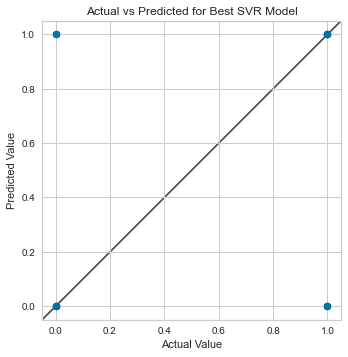

best score: 0.750000
average score: 0.635813 
Cohen Kappa: 0.352941
Extracting Confidence Intervals scores for the matrix
overall precision: 0.59036145, recall: 0.58333333
precision range for 1: 0.48192771 to 0.69879518
recall range for 1: 0.47619048 to 0.69047619
overall precision: 0.59770115, recall: 0.60465116
precision range for 2: 0.49425287 to 0.70114943
recall range for 2: 0.50000000 to 0.70930233
LogisticRegression(C=10000, max_iter=8000, penalty='l1', solver='liblinear')
              precision    recall  f1-score   support

     Healthy       0.65      0.69      0.67        16
          PD       0.71      0.67      0.69        18

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.68        34
weighted avg       0.68      0.68      0.68        34

Ridge


C:\Users\te5msride\.conda\envs\gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


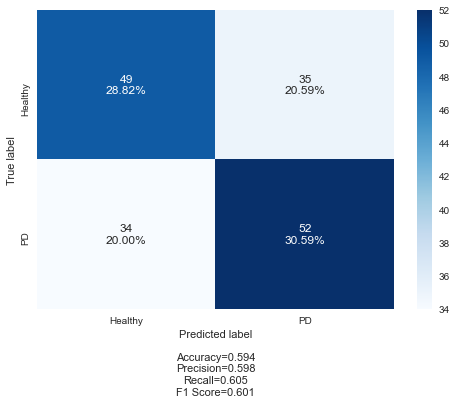

In [19]:
print("Log Reg (l1)")
#alpha from 10^-5 to 10^5
#remove solver
#hyperparameters selected for the models selected
#compare results with original paper
#look at inter-rater reliability for comparison (clinician 1 vs clinician 2) 
#kappa values between prediction - cinician diagnosis

params = {'solver':['liblinear'],
         'C':[pow(10, i)for i in range (-5, 5)]}
best_log_l1, log_l1_scoring = outer_cross_val(X, Y, groups, selection, LogisticRegression(penalty='l1',max_iter=8000), params, testing, 3)
log_l1_score, average_log_l1, log_l1_cm, Y_test, Y_pred, log_l1_fpr, log_l1_tpr,l1_train_index, l1_test_index= log_l1_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)
best_log_l1_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_log_l1_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
print("best score: %.6f" % log_l1_score)
print("average score: %.6f " % average_log_l1)
print("Cohen Kappa: %.6f" % best_log_l1_kappa)
#print("Consolidated Confusion Matrix ")
#print(log_l1_cm)
label = ['Healthy', 'PD']
result_cm = matrix_scores(log_l1_cm.astype(float))
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(log_l1_cm)))
print(best_log_l1)
#print(best_log_l1.coef_)
print(metrics.classification_report(Y_test, Y_pred_q, target_names = categories))
print("Ridge")
make_confusion_matrix(log_l1_cm, categories = categories)
#sns.heatmap(log_l1_cm, annot=True)

In [ ]:
print("Random Forest Classifier")

params_RF = {'n_estimators':[a*10 for a in range(1,5)]
            ,'max_depth':[i for i in range(2, 10)]
            , 'criterion':['gini']
            }

best_RF_classifier, RFC_scoring = outer_cross_val(X, Y, groups, selection, RandomForestClassifier(), params_RF, testing, 3)
RFC_score, average_RFC, RFC_cm, Y_test, Y_pred, RFC_fpr, RFC_tpr, _, _ = RFC_scoring
Y_pred_q = np.round_(Y_pred, decimals=0)  
best_RFC_cm = metrics.confusion_matrix(Y_test, Y_pred, labels_for_matrix)
best_RFC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)

print("best score - accuracy: %.6f" % RFC_score)
print("average score: %.6f " % average_RFC)
#print("Best Confusion Matrix ")
#print(best_RFC_cm)

print("Cohen Kappa: %.6f" % best_RFC_kappa)
#print("Consolidated Confusion Matrix ")
#print(RFC_cm)
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(RFC_cm)))
print(best_RF_classifier)
print(metrics.classification_report(Y_test, Y_pred_q, target_names = categories))
#use the model to predict
RFC_model = best_RF_classifier.predict(X)
#print("Testing the model on the data set")
#print(metrics.confusion_matrix(Y, Y_model, labels_for_matrix))
#print(metrics.classification_report(Y, Y_model))
print("Random Forest Classifier")
make_confusion_matrix(RFC_cm, categories = categories)

In [ ]:
#DecisionTreeClassifier
print("DecisionTreeClassifier")
params = {'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split':[i for i in range(2, 10)]}

best_DTC, DTC_scoring = outer_cross_val(X, Y, groups, selection, 
                                            DecisionTreeClassifier(), params, testing, 2)
DTC_score, average_rm, DTC_cm, Y_test, Y_pred, DTC_fpr, DTC_tpr, _, _ = DTC_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)

best_DTC_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_DTC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
# print("best score - accuracy : %.6f" % DTC_score)
print("average score: %.6f " % average_rm)
# print("Best Confusion Matrix ")
# print(best_Decision_Tree_cm)
print(metrics.classification_report(Y_test, Y_pred_q))
print("Cohen Kappa: %.6f" % best_DTC_kappa)
print(best_DTC)
make_confusion_matrix(DTC_cm, categories = categories)

In [ ]:
#KNNClassifier
print("K-Nearest Neighbors Classifier")
params = {'n_neighbors':[i for i in range(2, 40)]}

best_KNN, KNN_scoring = outer_cross_val(X, Y, groups, selection, KNeighborsClassifier(), params, testing, 2)
KNN_score, average_knn, KNN_cm, Y_test, Y_pred, KNN_fpr, KNN_tpr, _, _ = KNN_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)

best_KNN_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_KNN_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
# print("best score - accuracy : %.6f" % KNN_score)
print("average score: %.6f " % average_knn)
# print("Best Confusion Matrix ")
# print(best_Decision_Tree_cm)
print(metrics.classification_report(Y_test, Y_pred_q))
print("Cohen Kappa: %.6f" % best_KNN_kappa)
print(best_KNN)
make_confusion_matrix(KNN_cm, categories = categories)

In [ ]:
# testing = 'Class_AUC'
# selection = StratifiedKFold()
#support vector classifier
print("Support vector classifier")


params_svc = {'gamma':[pow(10,i) for i in range(5,-6, -1)], 'C':[pow(10,j) for j in range(-5, 6, 1)]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, groups, selection, SVC(probability=True), params_svc, testing, 2)

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr, SVC_train_index, SVC_test_index = SVC_scoring
Y_pred_q = np.round_(Y_pred, decimals=0)  
print("best score - AUC: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
#print("Consolidated Confusion Matrix ")
#print(SVC_cm)
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))

best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)
print(metrics.classification_report(Y_test, Y_pred, target_names=categories))
#use the model to predict
SVC_model = best_SVC.predict(X)

#print("Testing the model on the data set")
#print(metrics.confusion_matrix(Y, Y_model, labels_for_matrix))
#print(metrics.classification_report(Y, Y_model))
#sns.heatmap(SVC_cm, annot=True)
print("Support Vector Classifier")
make_confusion_matrix(SVC_cm, categories = categories)

In [ ]:
print(groups[SVC_train_index])
print(groups[SVC_test_index])

In [ ]:
misclass = {'Subject': groups[SVC_test_index], 'Actual': Y_test, 'Predicted': Y_pred_q}
df_misclass = pd.DataFrame(misclass)
# df_misclass['Subject'] = groups[SVC_index]
# df_misclass['Actual'] = Y_test
# df_misclass['Predicted'] = Y_pred_q
df_misclass.reset_index(inplace=False)
# df.style.apply(lambda x: ['background:grey' if x in highlight else 'background:white' for x in df.Employee])
df_misclass

In [ ]:
plt.plot(log_l1_fpr, log_l1_tpr, marker='.', markersize=12, label='L1 Log Reg (AUROC = %0.3f)' % log_l1_score)
plt.plot(log_l2_fpr, log_l2_tpr, marker='.', markersize=12, label='L2 Log Reg (AUROC = %0.3f)' % log_l2_score)
plt.plot(RFC_fpr, RFC_tpr, marker='.', markersize=12, label='RFC (AUROC = %0.3f)' % RFC_score)
plt.plot(SVC_fpr, SVC_tpr, marker='.', markersize=12, label='SVC (AUROC = %0.3f)' % SVC_score)
plt.plot(DTC_fpr, DTC_tpr, marker='.', markersize=12, label='DTC (AUROC = %0.3f)' % DTC_score)
plt.plot(KNN_fpr, KNN_tpr, marker='.', markersize=12, label='KNN (AUROC = %0.3f)' % KNN_score)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig((r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\Class.svg' ))
plt.show()


In [ ]:
#support vector classifier
print("Support vector classifier")


params_svc = {'gamma':[pow(10,i) for i in range(5,-6, -1)], 'C':[pow(10,j) for j in range(-5, 6, 1)]}

best_SVC, SVC_scoring = outer_cross_val(transform_X, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr = SVC_scoring
Y_pred_q = np.round_(Y_pred, decimals=0)  
print("best score - AUC: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
#print("Consolidated Confusion Matrix ")
#print(SVC_cm)
#print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))

best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)
print(metrics.classification_report(Y_test, Y_pred, target_names=categories))
#use the model to predict
SVC_model = best_SVC.predict(transform_X)

#print("Testing the model on the data set")
#print(metrics.confusion_matrix(Y, Y_model, labels_for_matrix))
#print(metrics.classification_report(Y, Y_model))
#sns.heatmap(SVC_cm, annot=True)
print("Support Vector Classifier")
make_confusion_matrix(SVC_cm, categories = categories)

In [ ]:
#Any p-values gathered should be passed through this function to adjust for error
#Change pvalues variable as needed for various tests.
r, pcorr, alph, ann = statsmodels.stats.multitest.multipletests(pvalues,alpha=.05,method='bonferroni')

# Autoencoder

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Classification Set
X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 69, 1)
groups = df_normalized.to_numpy()[:, 0]
categories = [ "Healthy", "PD"]

val_roc,roc,dim=[],[],[]
ae_results = []



n_inputs = (37)
inputs = Input(shape=(n_inputs))

encoded_dim = [2, 3, 4]
for i in range(6, 30, 2):
    encoded_dim.append(i)

for i in encoded_dim:
    #Encoder
    #encoded = Dropout(.2,  seed=32)(inputs)
    encoded = Dense(i, activation='relu')(inputs)
    #encoded = Dense(100, activation='relu')(encoded)
    #encoded = Dense(encoded_dim, activation='relu')(encoded)

    #Decoder
    #decoded = Dense(100, activation='linear')(encoded)
    decoded = Dense(n_inputs,activation='linear')(encoded)
    #decoded = Dense(n_inputs)(decoded)

    #Model setup, summary and compilation
    autoencoder = Model(inputs, decoded)
    plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)
    autoencoder.summary()
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

    history = autoencoder.fit(X, X,
                    epochs=300,
                    batch_size = 512,
                    verbose =2,
                    shuffle = True,
                    validation_split=.2
                   )


    encoded_X = encodeX(X,inputs,encoded)

    encoder = Model(inputs, encoded)
    decoder_output = encoder.predict(X)
    best_SVC, SVC_scoring = outer_cross_val(decoder_output, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
    SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr = SVC_scoring
    #print(SVC_score)
    metric = SVC_score
    # plot loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('# of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('# of epochs')
    plt.ylabel('f1')
    plt.legend()
    plt.show()
    
    ae_results.append([i, metric])
    #roc_list.append(auc)
    #var_list.append(var)
    roc.append(history.history['accuracy'][-1])
    val_roc.append(history.history['val_accuracy'][-1])
    dim.append(i)
    
    
fig = plt.figure()
# summarize history for accuracy
plt.plot(dim,roc)
plt.plot(dim,val_roc)
# plt.plot(history.history['val_acc'])

plt.title('Sample Size vs ROC')
plt.ylabel('ROC')
plt.xlabel('Dimensions')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy.png')
plt.show()

In [ ]:
n_inputs = (37)
inputs = Input(shape=(n_inputs))
#Encoder
#encoded = Dropout(.2,  seed=32)(inputs)
encoded = Dense(26, activation='relu')(inputs)
#encoded = Dense(100, activation='relu')(encoded)
#encoded = Dense(encoded_dim, activation='relu')(encoded)

#Decoder
#decoded = Dense(100, activation='linear')(encoded)
decoded = Dense(n_inputs,activation='linear')(encoded)
#decoded = Dense(n_inputs)(decoded)

#Model setup, summary and compilation
autoencoder = Model(inputs, decoded)
plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)
autoencoder.summary()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

history = autoencoder.fit(X, X,
                epochs=300,
                batch_size = 512,
                verbose =2,
                shuffle = True,
                validation_split=.2
               )


encoded_X = encodeX(X,inputs,encoded)

encoder = Model(inputs, encoded)
decoder_output = encoder.predict(X)
best_SVC, SVC_scoring = outer_cross_val(decoder_output, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr = SVC_scoring
#print(SVC_score)
metric = SVC_score
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('# of epochs')
plt.ylabel('f1')
plt.legend()
plt.show()

In [ ]:
num = [i[0] for i in ae_results]
met = [i[1] for i in ae_results]
plt.plot(num, met)

In [ ]:
#Encoder
#encoded = Dropout(.2,  seed=32)(inputs)
encoded = Dense(26, activation='relu')(inputs)
#encoded = Dense(100, activation='relu')(encoded)
#encoded = Dense(encoded_dim, activation='relu')(encoded)

#Decoder
#decoded = Dense(100, activation='linear')(encoded)
decoded = Dense(n_inputs,activation='linear')(encoded)
#decoded = Dense(n_inputs)(decoded)

#Model setup, summary and compilation
autoencoder = Model(inputs, decoded)
plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)
autoencoder.summary()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

history = autoencoder.fit(X, X,
                epochs=500,
                batch_size = 512,
                verbose =2,
                shuffle = True,
                validation_split=.2
               )


encoded_X = encodeX(X,inputs,encoded)

encoder = Model(inputs, encoded)
decoder_output = encoder.predict(X)
best_SVC, SVC_scoring = outer_cross_val(decoder_output, Y, groups, selection, SVC(probability=True), params_svc, testing, 3)
SVC_score, average_SVC, SVC_cm, Y_test, Y_pred,SVC_fpr, SVC_tpr = SVC_scoring
#print(SVC_score)
metric = SVC_score
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('# of epochs')
plt.ylabel('f1')
plt.legend()
plt.show()
make_confusion_matrix(SVC_cm, categories = categories)

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Classification Set
X, Y = x_y_split_data(df_normalized.to_numpy(), 33, 106, 1)
groups = df_normalized.to_numpy()[:, 0]
categories = [ "Healthy", "PD"]

val_roc,roc,dim=[],[],[]


n_inputs = (74)
inputs = Input(shape=(n_inputs))

encoded_dim = [2, 3, 4]
for i in range(5, 30, 1):
    encoded_dim.append(i)

for i in encoded_dim:
    #Encoder
    #encoded = Dropout(.2,  seed=32)(inputs)
    encoded = Dense(i, activation='relu')(inputs)
    #encoded = Dense(100, activation='relu')(encoded)
    #encoded = Dense(encoded_dim, activation='relu')(encoded)

    #Decoder
    #decoded = Dense(100, activation='linear')(encoded)
    decoded = Dense(n_inputs,activation='relu')(encoded)
    #decoded = Dense(n_inputs)(decoded)

    #Model setup, summary and compilation
    autoencoder = Model(inputs, decoded)
    plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)
    autoencoder.summary()
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[f1_m])

    history = autoencoder.fit(X, X,
                    epochs=300,
                    batch_size = 512,
                    verbose =2,
                    shuffle = True,
                    validation_split=.2
                   )


    encoded_X = encodeX(X,inputs,encoded)

    encoder = Model(inputs, encoded)
    decoder_output = encoder.predict(X)
    # plot loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('# of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    plt.plot(history.history['f1_m'], label='train')
    plt.plot(history.history['val_f1_m'], label='test')
    plt.xlabel('# of epochs')
    plt.ylabel('f1')
    plt.legend()
    plt.show()
    
    results.append([c, auc, var])
    roc_list.append(auc)
    var_list.append(var)
    roc.append(history.history['f1_m'][-1])
    val_roc.append(history.history['val_f1_m'][-1])
    dim.append(i)
    
fig = plt.figure()
# summarize history for accuracy
plt.plot(dim,roc)
plt.plot(dim,val_roc)
# plt.plot(history.history['val_acc'])

plt.title('Sample Size vs ROC')
plt.ylabel('ROC')
plt.xlabel('Dimensions')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy.png')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(dim,roc)
plt.plot(dim,val_roc)

plt.title('Sample Size vs ROC')
plt.ylabel('ROC')
plt.xlabel('Dimensions')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy.png')
plt.show()